# Jupyter Notebook for the analysis of the Model for Retinoic Acid resistance in Acute Promyelocytic Leukaemia

José A. Sánchez-Villanueva (1), Lia N’Guyen (2), Mathilde Poplineau (2), Estelle Duprez (2), Élisabeth Remy (1) & Denis Thieffry (3,4)     
1) Aix Marseille Univ, CNRS, I2M, Marseille, France.  
2) Integrative molecular biology in hematopoiesis and leukemia, Equipe Labellisée Ligue Contre le Cancer, CRCM, Inserm UMR1068, CNRS UMR7258, Institut Paoli-Calmettes, Aix Marseille Univ, Marseille, France.  
3) Department of Biology, École Normale Supérieure, Paris, France.   
4) Institut Curie - INSERM U900 - Mines Paris, PSL Research University, Paris, France.


This model analysis workflow was designed to assses the dynamical properties of a logical network model constructed to study Retinoic Acid resistance in Acute Promyelocytic Leukaemia. Execution of the command lines requires installation of the CoLoMoTo environment (https://colomoto.github.io/).  
The model integrates signalling, transcriptional and epigenetic regulatory mechanisms underlying the APL cell responses to RA treatment depending on their genetic background. The explicit inclusion of the histone methyltransferase EZH2 allowed to assess its role in the maintenance of the resistant phenotype, distinguishing between its canonical and non-canonical activities. Ultimately, this model offers a solid basis to assess the roles of novel regulatory mechanisms, as well as to explore novel therapeutical approaches *in silico*.

The analysis workflow includes the following steps:

* loading of the logical model from the GINsim repository and display of the logical regulatory graph(LRG),
* identification of the attractors (trapspaces and fixpoints),
* attractors commitment analysis,
* definition of variants of the model to represent EZH2 perturbations cases,
* stochastic simulations to evaluate the impact of EZH2 perturbations on the probabilities to reach the differentiated and proliferative phenotypes,
* a comprehensive perturbation analysis to determine the nodes with stronger contributions to the differentiated or proliferative phenotypes,
* a parameter sensitivity analysis focused on variations in the activation and deactivation transition rates.

In [1]:
# Import of the necessary tools and python packages for the whole set of analyses.

import ginsim
import biolqm
import pyboolnet
import maboss

from colomoto_jupyter import tabulate

from pyboolnet.file_exchange import bnet2primes, primes2bnet
from pyboolnet.prime_implicants import find_constants, create_variables, list_input_combinations, create_constants
from pyboolnet.repository import get_primes
from pyboolnet.trap_spaces import compute_trap_spaces, compute_steady_states

from pyboolnet.model_checking import model_checking
from pyboolnet.attractors import compute_attractors
from pyboolnet.commitment_diagrams import compute_commitment_diagram, create_commitment_piechart, commitment_diagram2image

This notebook has been executed using the docker image `colomoto/colomoto-docker:for-next`

INFO generated new fontManager


## Loading of the logical model and displaying of the Logical Regulatory Graph with GINsim

In [2]:
# Load the model in GINsim format and display the Logical Regulatory Graph.
lrg = ginsim.load("SanchezVillanueva_RA_APL_model_19Nov2024.zginml")  # To load the model file stored locally
# lrg = ginsim.load("http://ginsim.org/sites/default/files/SanchezVillanueva_RA_APL_model_19Aug2024.zginml")  # To load the model file from the GINsim repository
ginsim.show(lrg)

This **logical regulatory graph** encompasses 36 nodes and 131 signed arcs. Internal nodes can be associated with four main functions: cell cycle arrest (red); cell cycle progression (green); granulocytic differentiation (yellow); and epigenetic regulation (orange), integrating components of 3 different layers (signalling, epigenetic and transcriptional) into a common regulatory graph. Oval nodes denote Boolean components, whereas the rectangular one denotes a ternary component (RA). Green arrows and red blunt arcs denote positive and negative regulatory influences, respectively. Three inputs nodes (light blue) denote the presence of translocations (PLM_RARAg or PLZF_RARAg), as well as the RA level considered (No RA: 0, physiological level: 1, and pharmacological level: 2). The graph is complemented with logical rules determining the target level of each node as a function of the levels of its regulators. The model (including logical rules and model annotations) is available in the GINsim repository (http://ginsim.org/node/256), as well as in the BioModels database (SBML qual format).

## Identification of the attractors with bioLQM

Logical model attractors can be of two types: single stable states (also named fixpoints), or cyclic attractors, made of circular sequences of two or more states, according to the logical rules.

The *trapspaces* function of bioLQM enables the identification of both types of attractors, while the *fixpoints* function only identifies the stable states. Using both functions we were able to detect that the number of stable states equals the number of minimal trapspaces, presumably ruling out the existence of cyclic attractors. This hypothesis is further verified with the commitment analysis showed below, as all states lead to the stable states in each of the diagrams.

In [3]:
# Computation of the number of trapspaces and fixpoints of the model.
lqm = ginsim.to_biolqm(lrg)
print("Number of attractors of the model:")
print("trapspaces: "+str(len(biolqm.trapspaces(lqm, "terminal"))))
print("stable states: "+str(len(biolqm.fixpoints(lqm)))+"\n")

Number of attractors of the model:
trapspaces: 21
stable states: 21



In [4]:
# Display of the stable states over selected reporter components
rep_comp = ["RA", "PML_RARAg", "PLZF_RARAg", "PML", "PLZF", "TP53", "CDKN1A", "CDKN1B", "E2F1", "MYC", "RARB", "CEBPAB", "EZH2", "PRC2", "SPI1"]
fps = biolqm.fixpoints(lqm)
fpsproj = biolqm.fixpoints(lqm, autoconvert=False).project_on_components(rep_comp)
display(biolqm.states_to_dataframe(fpsproj).style.set_properties(**{'text-align': 'center'}))

The resulting stable states are listed, focusing on the values of a subset of nodes enabling the association of each of the stable states with a specific cellular phenotype.
The list covers all possible input combinations, including situations corresponding to the simultaneous presence of PML_RARAg and PLZF_RARAg fusions, which has never been reported. This genetic background is thus not further considered in the simulations presented below.  
Using GINsim, we can also visualise any of these stable states directly on the regulatory graph.

In [5]:
# Display the 8th stable state on the regulatory graph 
ginsim.show(lrg, fps[8])

Nodes in blue are active, while the nodes in white are inactive. This stable state thus corresponds to the differentiated phenotype reached in the presence of medium level of RA (light blue), but in the absence of PML-RARA and PLZF-RARA fusion proteins.

## Commitment analysis with pyboolnet
PyBoolnet can be used to compute the set of states leading towards each of the attractors. 
It relies in the model checking tool NuSMV.  
A commitment diagram is generated for each of the input combinations. 
The resulting diagrams are saved in json format and as images in PDF format.

In [6]:
%%time

# Export of the biolqm model to pyboolnet for commitment analysis
bnet = biolqm.save(lqm, "bnet.bnet", "bnet")
pbn = bnet2primes(bnet)

CPU times: user 37.9 ms, sys: 9.94 ms, total: 47.8 ms
Wall time: 1min 1s


In [7]:
%%time 

# Definition and storing of the relevant input combinations into a dictionary

pbn_input_configurations = {
    'WT_RA0_pbn': {'PLZF_RARAg': 0, 'PML_RARAg': 0, 'RA_b1': 0, 'RA_b2': 0},
    'WT_RA1_pbn': {'PLZF_RARAg': 0, 'PML_RARAg': 0, 'RA_b1': 1, 'RA_b2': 0},
    'WT_RA2_pbn': {'PLZF_RARAg': 0, 'PML_RARAg': 0, 'RA_b1': 1, 'RA_b2': 1},
    'PM_RA0_pbn': {'PLZF_RARAg': 0, 'PML_RARAg': 1, 'RA_b1': 0, 'RA_b2': 0},
    'PM_RA1_pbn': {'PLZF_RARAg': 0, 'PML_RARAg': 1, 'RA_b1': 1, 'RA_b2': 0},
    'PM_RA2_pbn': {'PLZF_RARAg': 0, 'PML_RARAg': 1, 'RA_b1': 1, 'RA_b2': 1},
    'PZ_RA0_pbn': {'PLZF_RARAg': 1, 'PML_RARAg': 0, 'RA_b1': 0, 'RA_b2': 0},
    'PZ_RA1_pbn': {'PLZF_RARAg': 1, 'PML_RARAg': 0, 'RA_b1': 1, 'RA_b2': 0},
    'PZ_RA2_pbn': {'PLZF_RARAg': 1, 'PML_RARAg': 0, 'RA_b1': 1, 'RA_b2': 1},
}

# Create the primes_dict using a loop
primes_dict = {name: create_constants(pbn, config, copy=True) for name, config in pbn_input_configurations.items()}



CPU times: user 4.09 ms, sys: 988 μs, total: 5.08 ms
Wall time: 5 ms


In [8]:
%%time  

# This cell computations take about 10'

# Commitment analysis for each of the input combinations. This step takes some time (around 20 mins on an Apple M1 Pro, 32 GB).
# A diagram in json format will be generated, and a PDF file with the image of the commitment diagram.
attractors_dict={}
diagrams_dict = {}
for k, v in primes_dict.items():
    attractors = compute_attractors(primes=v, update="asynchronous")
    attractors_dict['attractors'+'_'+str(k)]=attractors
    diagram = compute_commitment_diagram(attractors=attractors, fname_json=str(k)+'_commitment_diagram.json', edge_data=True)
    diagrams_dict['diagram'+'_'+str(k)]=diagram
    if len(attractors_dict['attractors'+'_'+str(k)]['attractors'])==1:
        continue
    commitment_diagram2image(diagram=diagram, fname_image=str(k)+'_commitment_diagram.pdf', style_inputs=True, style_edges=True, style_ranks=True, first_index= 1)

INFO attractors.completeness(..)
INFO created /tmp/pyboolnet_n3n6jf4z
INFO yes
INFO  working on minimal trapspace 1/2: 1111110000011011011000000111000011001
INFO attractors.univocality(..)
INFO  yes
INFO attractors.faithfulness(..)
INFO yes
INFO attractors.find_attractor_state_by_randomwalk_and_ctl(..)
INFO find_attractor_state_by_randomwalk_and_ctl(..)
INFO len(primes)=37, update='asynchronous', length=370, attempts=10
INFO trial 0
INFO start: 1111110000011011011000000111000011001
INFO end: 1111110000011011011000000111000011001
INFO created /tmp/pyboolnet_iefatc4k
INFO is attractor state
INFO  working on minimal trapspace 2/2: 0000001100011101100100100101000110010
INFO attractors.univocality(..)
INFO  yes
INFO attractors.faithfulness(..)
INFO yes
INFO attractors.find_attractor_state_by_randomwalk_and_ctl(..)
INFO find_attractor_state_by_randomwalk_and_ctl(..)
INFO len(primes)=37, update='asynchronous', length=370, attempts=10
INFO trial 0
INFO start: 0000001100011101100100100101000110

# Analysis of EZH2 perturbations  
In order to analyse the role of EZH2 in cell fate decision, we consider two variants of the APL model:  
i) a complete knockdown of EZH2, or the use of a specific degrader such as MS1943 (model variant EZH2 KO);  
ii) an edgetic perturbation amounting to block the regulatory influence of EZH2 onto PCR2, mimicking the experimental inhibition of EZH2 methyltransferase activity with a chemical agent such as GSK126 (model variant EZH2:PRC2%0)

## Definition of EZH2 Model variants with bioLQM

In [9]:
# Definition of mutants with biolqm, and storing into a dictionary

lqm = ginsim.to_biolqm(lrg)
lqm_EZH2_PRC20 = biolqm.perturbation(lqm, "EZH2:PRC2%0")
lqm_EZH2KO = biolqm.perturbation(lqm, "EZH2%0")

lqm_models = {'No perturbation':lqm, 'EZH2:PRC2%0':lqm_EZH2_PRC20, 'EZH2 KO':lqm_EZH2KO}

## Computation of the attractors for the two EZH2 model variants with bioLQM

In [10]:
# Computation of the number of trapspaces and fixpoints for the two EZH2 perturbations with bioLQM.

print("Number of attractors for the edgetic perturbation affecting the effect of EZH2 onto PRC2 (EZH2:PRC2%0):")
print("trapspaces: "+str(len(biolqm.trapspaces(lqm_EZH2_PRC20, "terminal"))))
print("stable states: "+str(len(biolqm.fixpoints(lqm_EZH2_PRC20)))+"\n")

print("Number of attractors for EZH2 knockout (EZH2 KO):")
print("trapspaces: "+str(len(biolqm.trapspaces(lqm_EZH2KO, "terminal"))))
print("stable states: "+str(len(biolqm.fixpoints(lqm_EZH2KO)))+"\n")

Number of attractors for the edgetic perturbation affecting the effect of EZH2 onto PRC2 (EZH2:PRC2%0):
trapspaces: 21
stable states: 21

Number of attractors for EZH2 knockout (EZH2 KO):
trapspaces: 12
stable states: 12



In [11]:
# Display of the fixpoints for the EZH2_PRC20 condition over selected reporter components.
rep_comp = ["RA", "PML_RARAg", "PLZF_RARAg", "PML", "PLZF", "TP53", "CDKN1A", "CDKN1B", "E2F1", "MYC", "RARB", "CEBPAB", "EZH2", "PRC2", "SPI1"]
fps_EZH2_PRC20 = biolqm.fixpoints(lqm_EZH2_PRC20, autoconvert=False).project_on_components(rep_comp)
display(biolqm.states_to_dataframe(fps_EZH2_PRC20).style.set_properties(**{'text-align': 'center'}))

After comparing this list with the list of stable states obtained above, we conclude that there is no significant impact of this epigenetic perturbation.

In [12]:
# Display of the fixpoints for the EZH2KO condition over selected reporter components.
fps_EZH2KO = biolqm.fixpoints(lqm_EZH2KO, autoconvert=False).project_on_components(rep_comp)
display(biolqm.states_to_dataframe(fps_EZH2KO).style.set_properties(**{'text-align': 'center'}))

The loss-of-function of EZH2 leads to the loss of the 9 stable states corresponding to the proliferative phenotype.

## Stochastic simulations to evaluate the impact of EZH2 perturbations in the PLZF::RARA background with MaBoSS
In order to further characterise the respective impacts of the two EZH2 peturbations, we performed stochastic simulations of the APL model for three conditions:  
* No perturbation  
* EZH2:PRC2%0  
* EZH2 KO

The simulations were performed with the software MaBoSS, using a state representing the Granulocyte-monocyte progenitor stage as initial state, under physiological (RA = 1) and pharmacological (RA = 2) levels of Retinoic Acid.   
The nodes PLZF_RARAg, RARA, PML, PLZF, USP37, CoAct_COMP, EZH2, PRC2, CoRep_COMP, CDKN2D, RB1, SKP2, MDM2, CAK, CCNA2, CCND1, CCNE2, CDK4_6, CDK2, E2F1, MYC, DUSP6, POU2F1, RUNX1, SPI1, CEBPAB and CEBPE all set to 1, while the rest of the nodes were set to 0.

In [13]:
# Convert each model variant to MaBoSS format and store in maboss_models dict.
maboss_models = {name: biolqm.to_maboss(model) for name, model in lqm_models.items()}

Warning, node RA_b1 was previously bound to other nodes
Warning, node RA_b1 was previously bound to other nodes
Warning, node RA_b1 was previously bound to other nodes
/opt/conda/lib/python3.11/site-packages/maboss/results/baseresult.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1,1)


CPU times: user 4.33 s, sys: 113 ms, total: 4.44 s
Wall time: 1min 20s


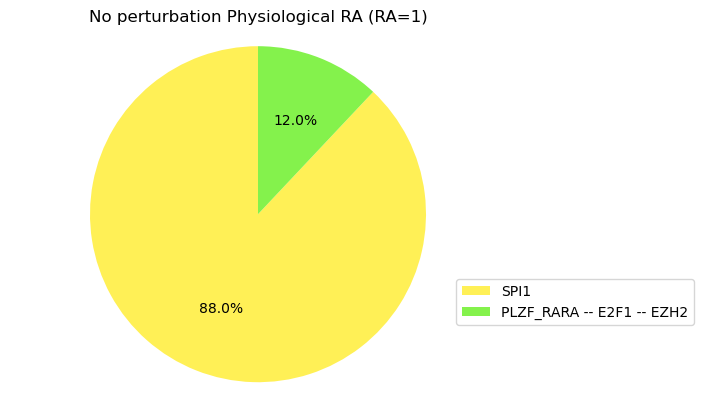

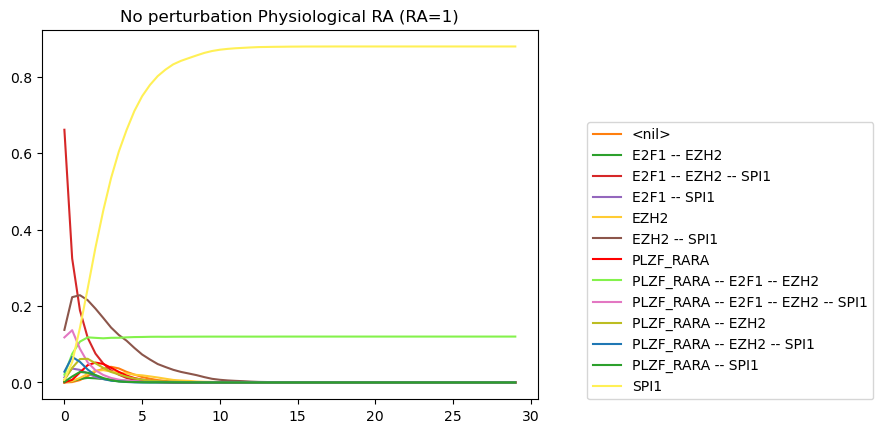

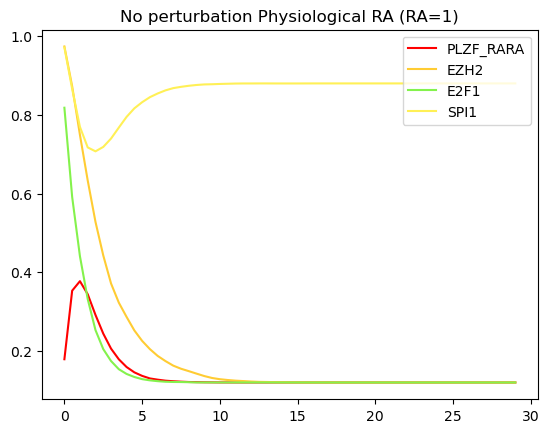

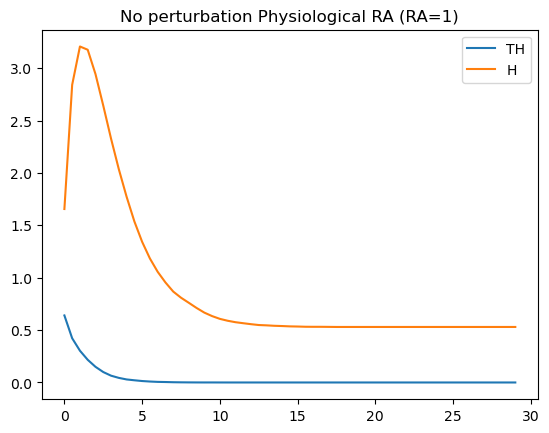

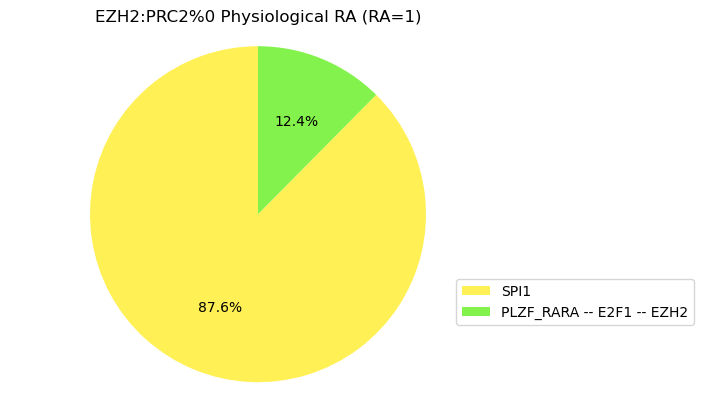

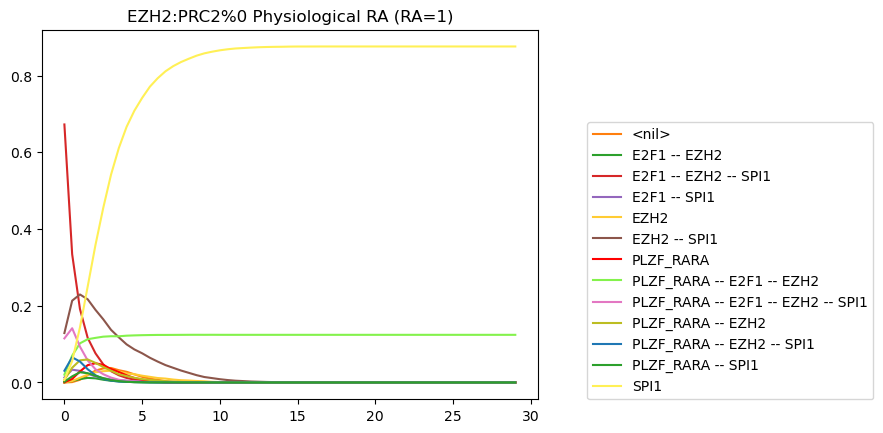

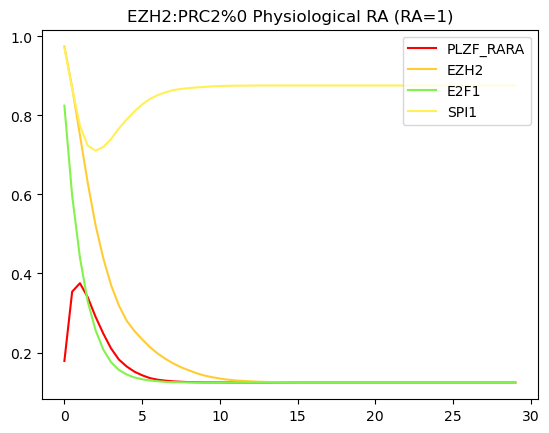

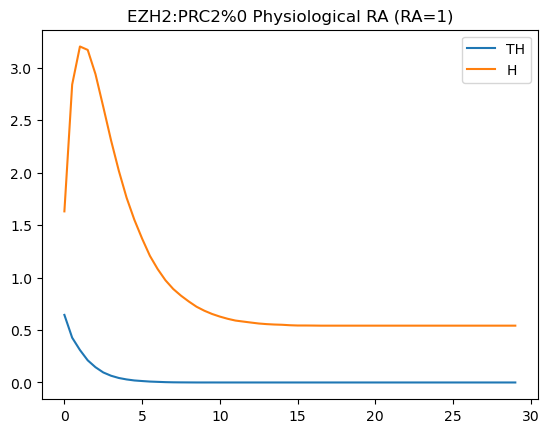

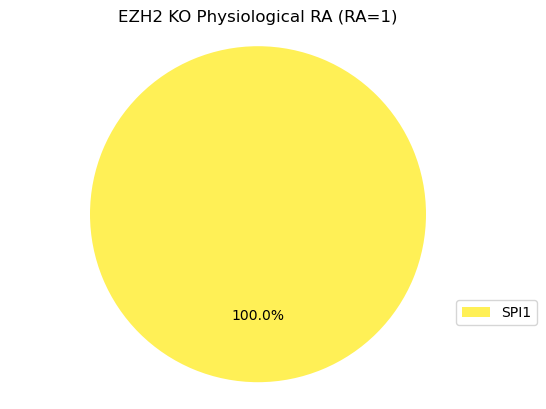

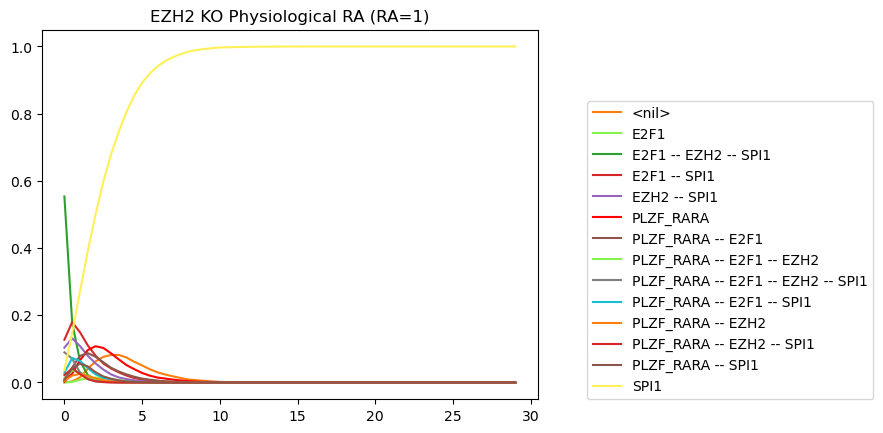

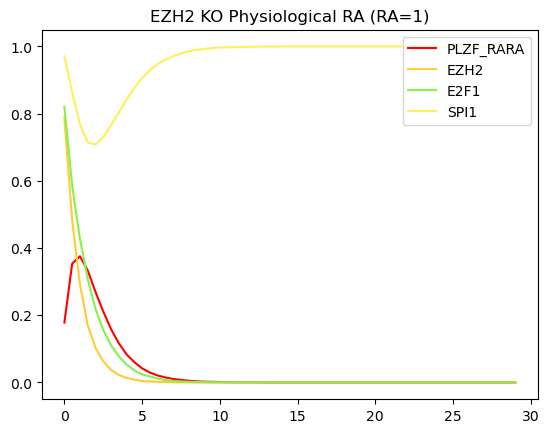

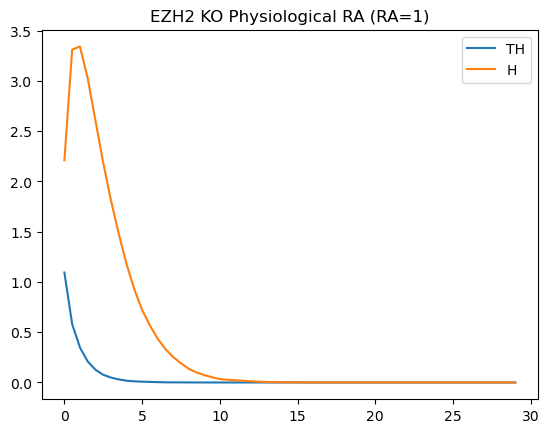

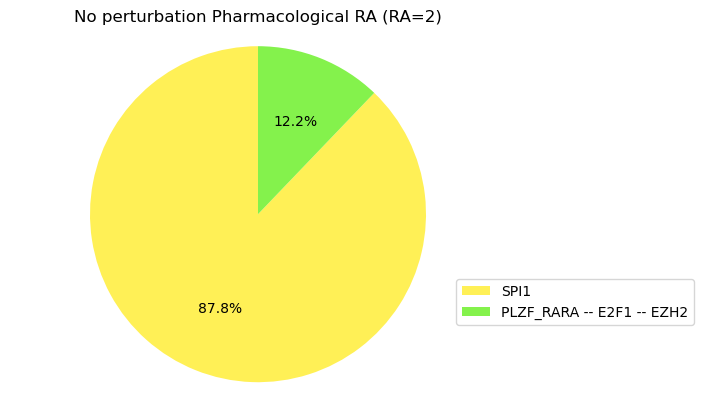

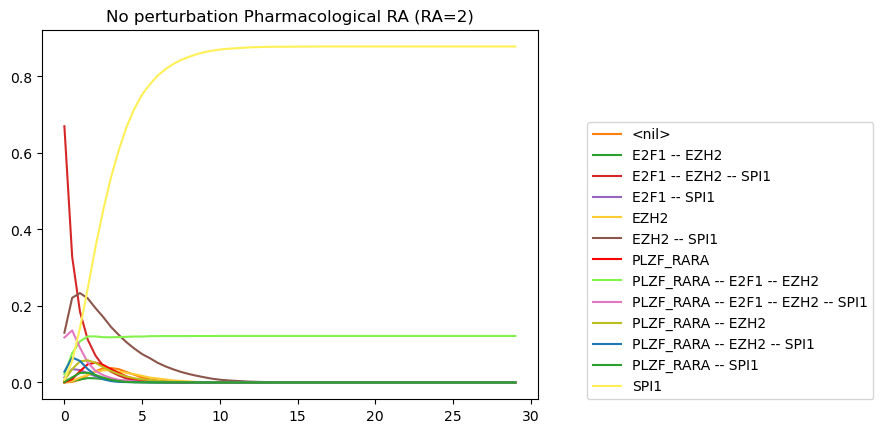

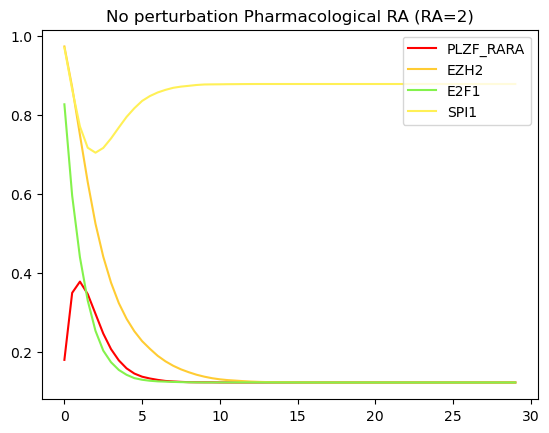

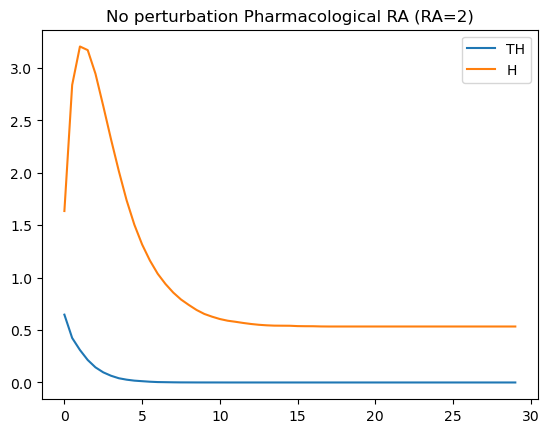

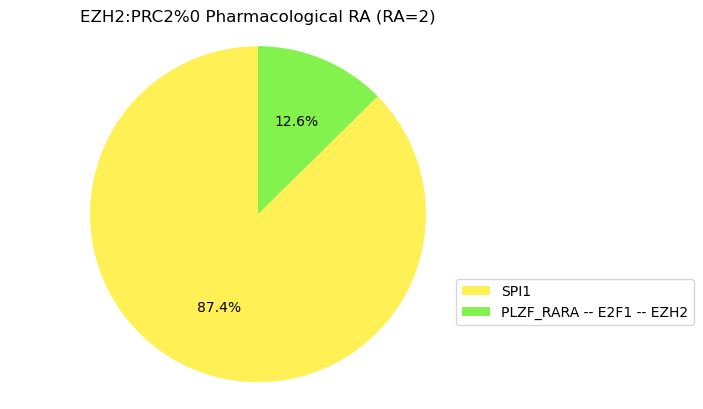

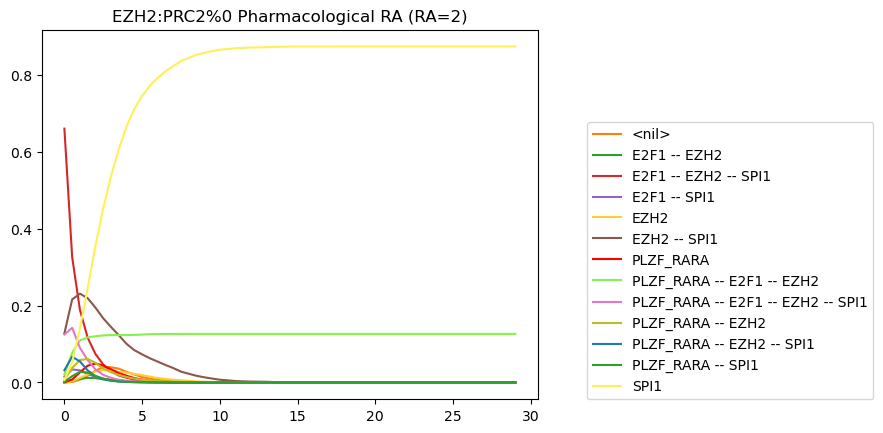

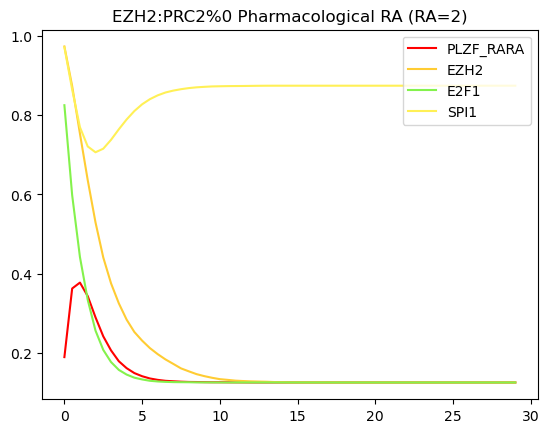

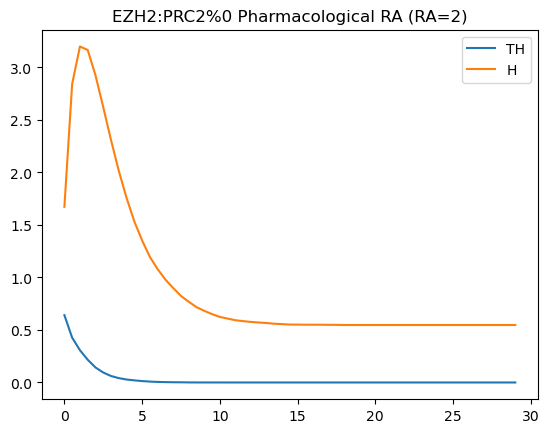

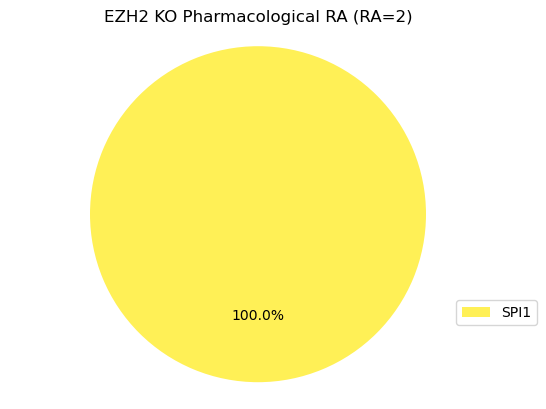

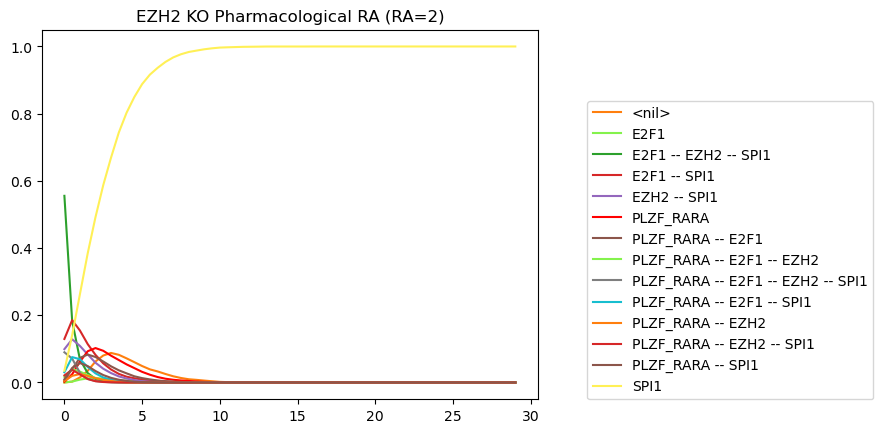

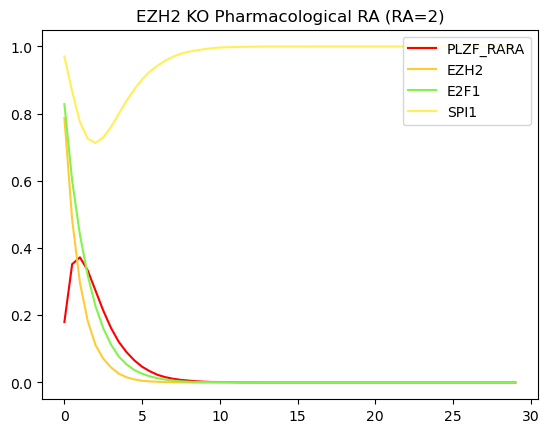

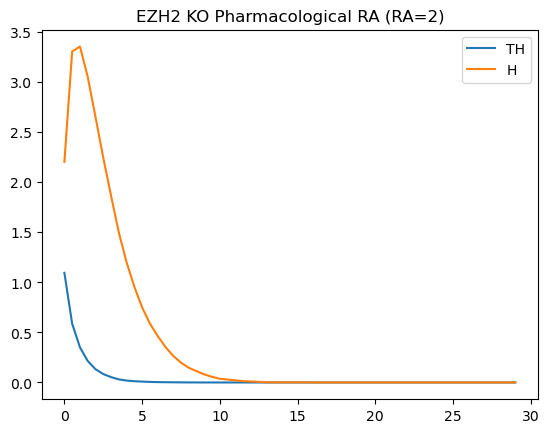

In [14]:
%%time  

# Stochastic simulations for the two EZH2 perturbation conditions + control, under physiological and pharmacological levels of Retinoic Acid.

import matplotlib.pyplot as plt

# Define the visualisation (color-node) pairs.
node_colors = {
    "E2F1": "#84F24C",
    "CDKN1A": "#FD817B",
    "CDKN1B": "#FD817B",
    "MYC": "#84F24C",
    "CEBPAB": "#FFF056",
    "SPI1": "#FFF056",
    "EZH2": "#FFCC33",
    "PLZF_RARA": "#FF0000",
    "CEBPAB -- CDKN1B": "#FFF056",
    "PLZF_RARA -- E2F1 -- EZH2": "#84F24C"
}

# Define the outputs
outputs = ["E2F1", "SPI1", "EZH2", "PLZF_RARA"]

# Define the nodes initial states
maboss_istates = {'Physiological RA (RA=1)' : [
    "RA_b1", "PLZF_RARAg", "RARA", "PML", "PLZF", "USP37", 
    "CoAct_COMP", "EZH2", "PRC2", "CoRep_COMP", "CDKN2D", 
    "RB1", "SKP2", "MDM2", "CAK", "CCNA2", "CCND1", 
    "CCNE2", "CDK4_6", "CDK2", "E2F1", "MYC", 
    "DUSP6", "POU2F1", "RUNX1", "SPI1", "CEBPAB", 
    "CEBPE"
], 'Pharmacological RA (RA=2)' : [
    "RA_b1", "RA_b2", "PLZF_RARAg", "RARA", "PML", "PLZF", "USP37", 
    "CoAct_COMP", "EZH2", "PRC2", "CoRep_COMP", "CDKN2D", 
    "RB1", "SKP2", "MDM2", "CAK", "CCNA2", "CCND1", 
    "CCNE2", "CDK4_6", "CDK2", "E2F1", "MYC", 
    "DUSP6", "POU2F1", "RUNX1", "SPI1", "CEBPAB", 
    "CEBPE"
]}

for name, istate in maboss_istates.items():
    
    # Loop over the models
    for k, v in maboss_models.items():
        # Apply node colors
        v.palette.update(node_colors)
    
        # Set outputs
        v.network.set_output(outputs)

        # Set the initial states for the nodes
        maboss.set_nodes_istate(v, istate, [0, 1])
    
        # Update parameters and run the simulation
        v.update_parameters(max_time=30)
        simres = v.run()
        
        # Plotting results
        simres.plot_piechart()
        plt.title(k+' '+name)
    
        simres.plot_trajectory()
        plt.title(k+' '+name)
    
        simres.plot_node_trajectory()
        plt.title(k+' '+name)
    
        simres.plot_entropy_trajectory()
        plt.title(k+' '+name)

The average results obtained over 10 000 MaBoSS simulations for each of the three conditions under physiological and pharmacological levels of RA are displayed.  
The time-plots show the evolution of the mean values of representative cell markers and cell states in time.  
The pie charts display the proportions of simulations leading to each stable state at the end of these simulations (i.e. at time 30, arbitrary units).  
The last plots display the evolution of the state entropy (H) and of the transition entropy (TH) over time.


From the comparison of the control with the EZH2:PRC2%0 case, we can conclude that the suppression of the influence of EZH2 onto PCR2 has a very marginal impact on cell fate decision.
In contrast, the full knockout of EZH2 (EZH2 KO) has a drastic impact on cell fate decision, eliminating the proliferative attractor.

# Comprehensive perturbation analysis with MaBoSS
In order to determine which nodes significantly impact cell fate decision, we can further use MaBoSS to perform stochastic simulations for gain-of-function and loss-of-function of selected nodes.  
Here also, a state representing the granulocyte-monocyte progenitor stage was used as initial state, with RA set to 2, PLZF_RARAg, RARA, PML, PLZF, USP37, CoAct_COMP, EZH2, PRC2, CoRep_COMP, CDKN2D, RB1, SKP2, MDM2, CAK, CCNA2, CCND1, CCNE2, CDK4_6, CDK2, E2F1, MYC, DUSP6, POU2F1, RUNX1, SPI1, CEBPAB, CEBPE all set to 1, while the rest of the nodes were set to 0.

/opt/conda/lib/python3.11/site-packages/maboss/results/baseresult.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1,1)


CPU times: user 7.32 s, sys: 657 ms, total: 7.97 s
Wall time: 11min 27s


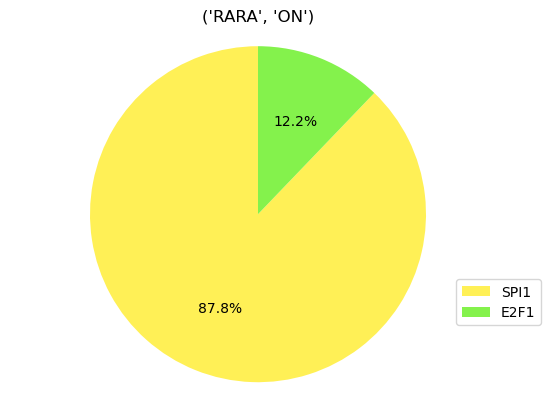

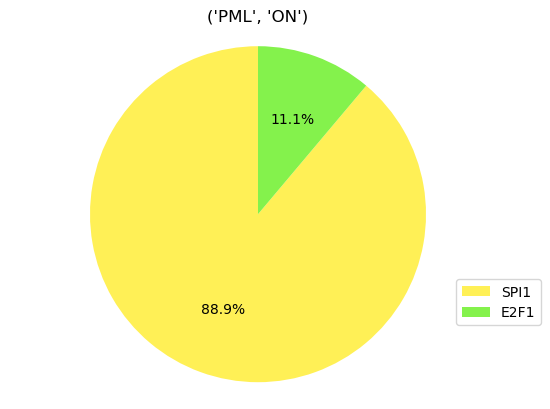

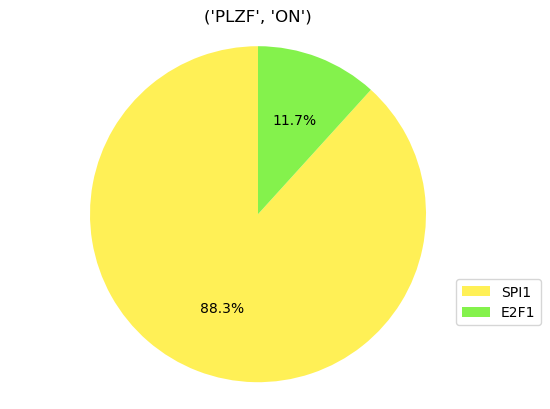

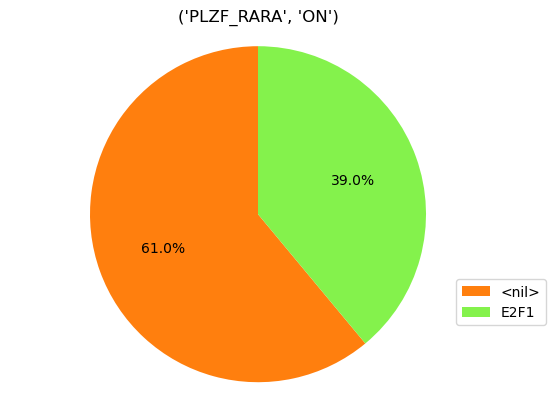

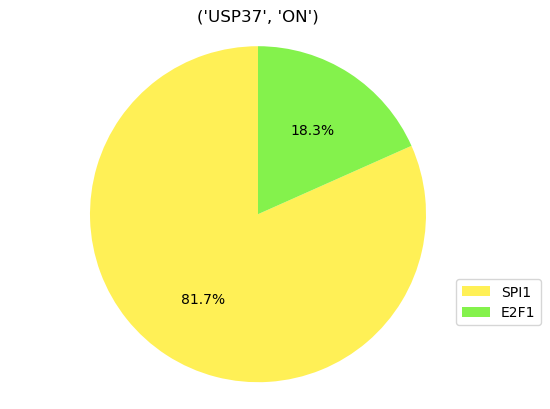

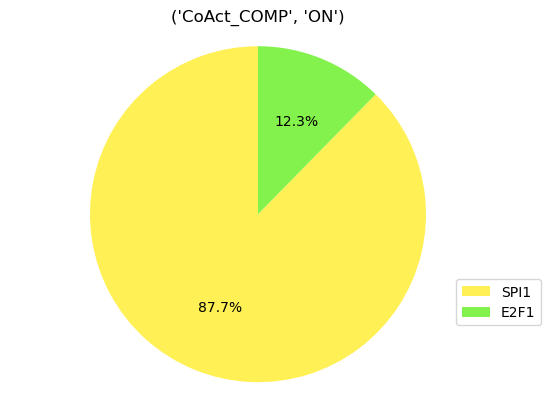

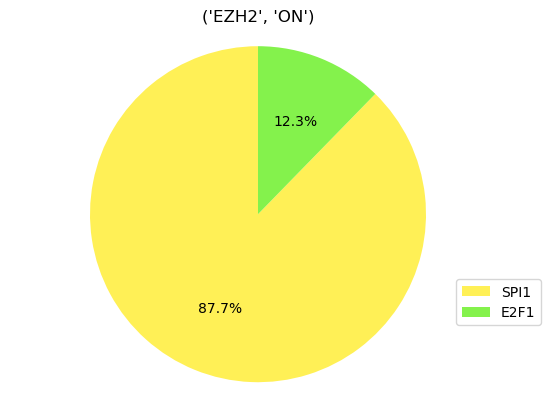

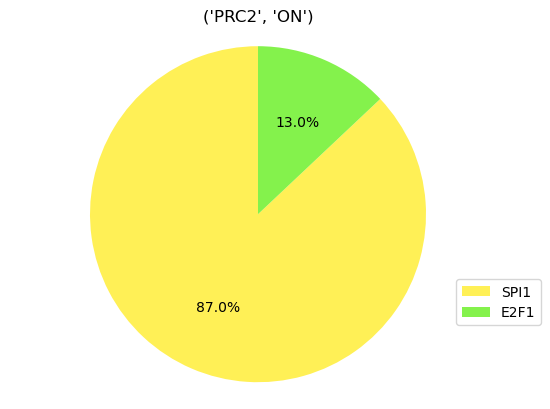

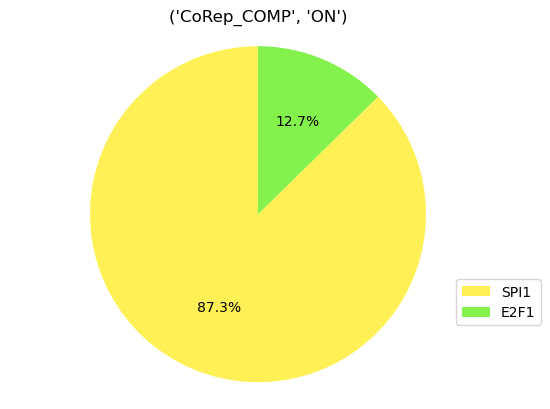

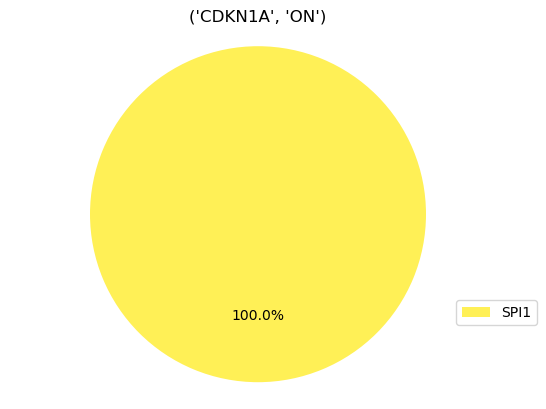

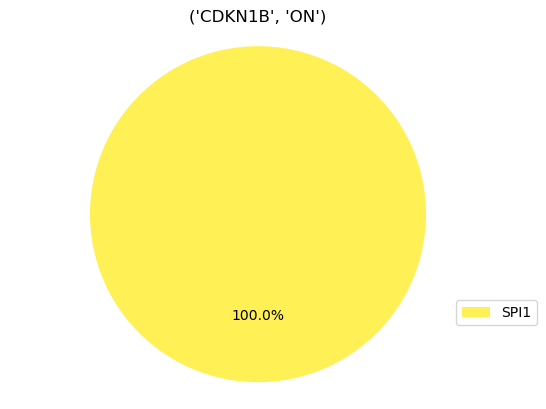

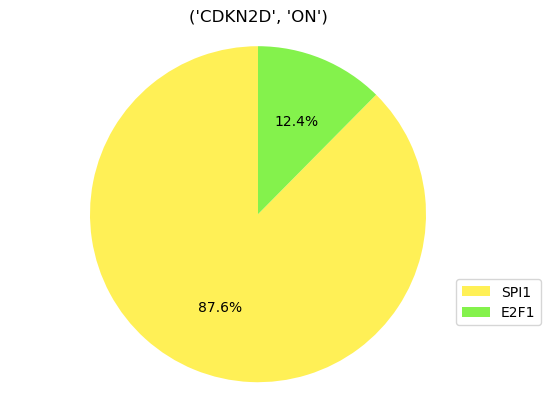

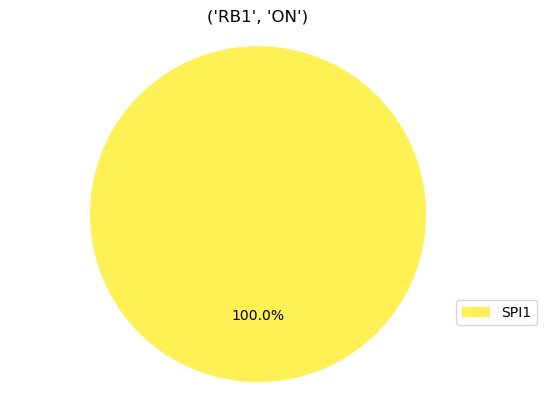

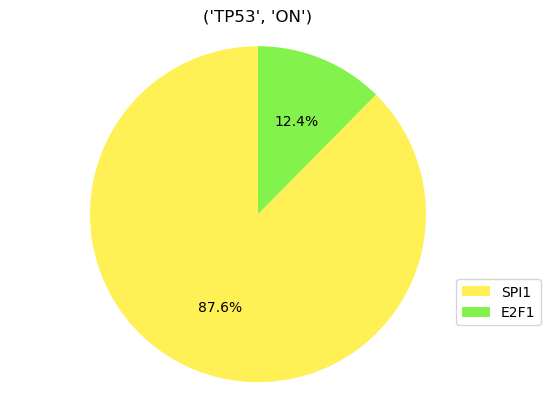

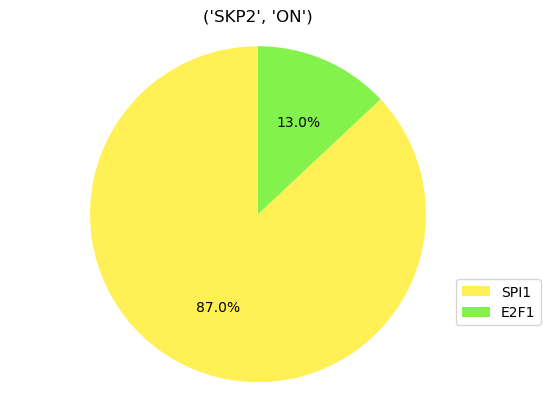

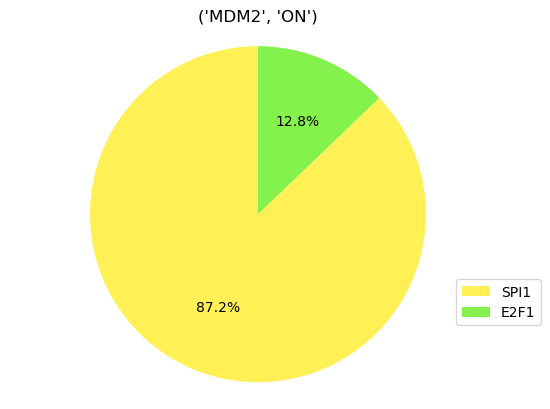

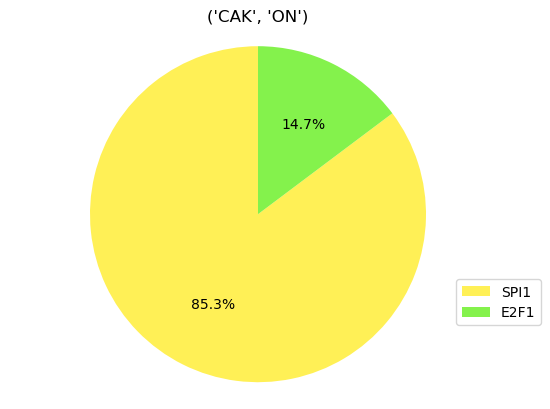

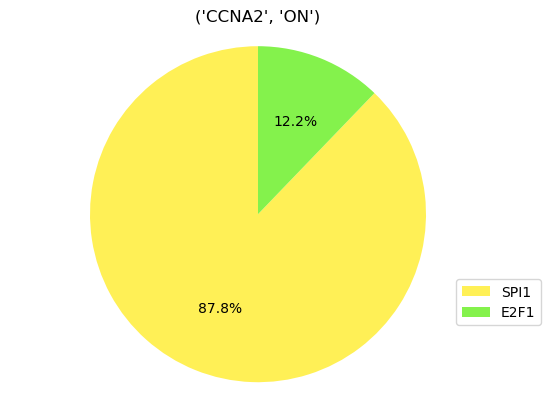

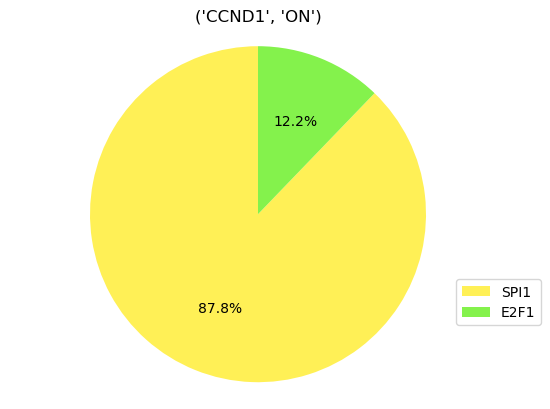

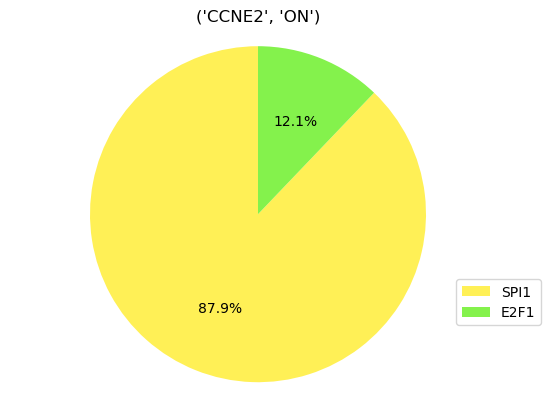

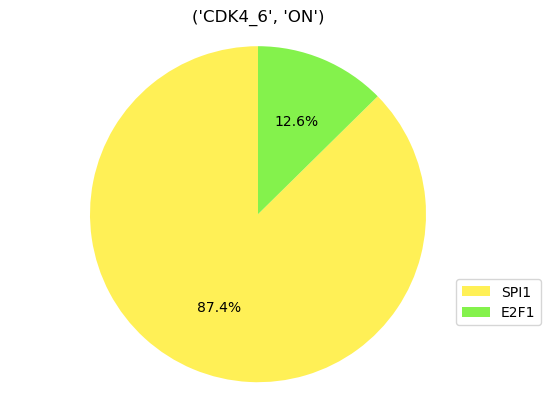

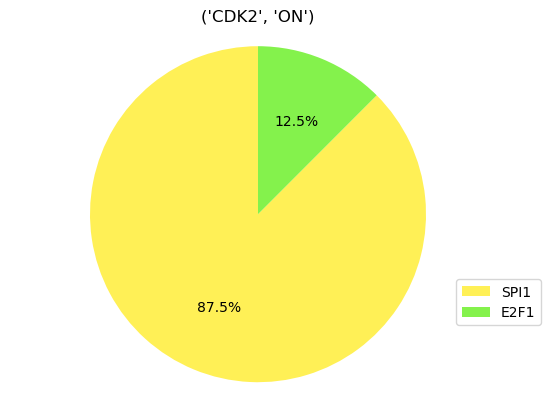

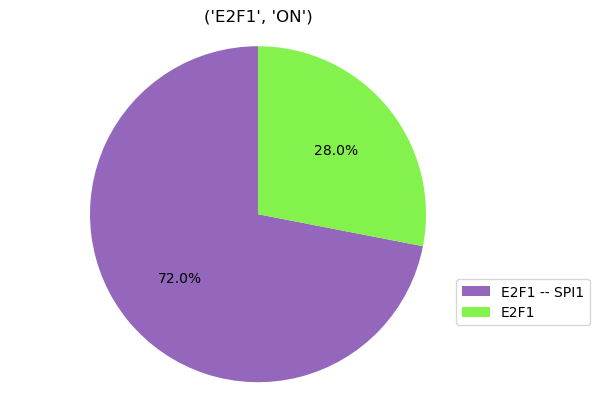

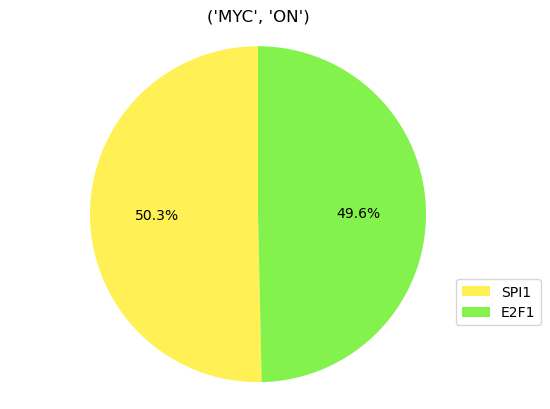

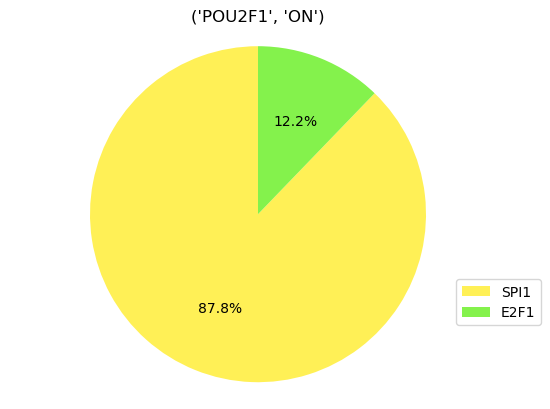

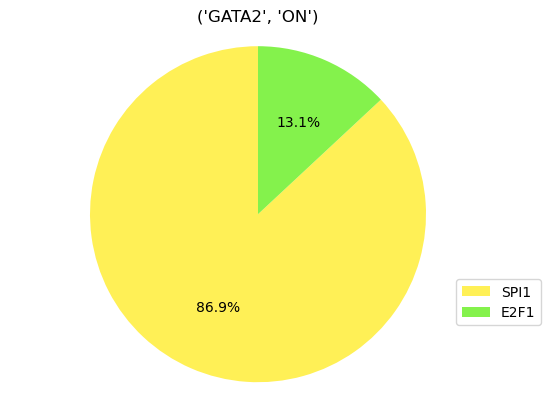

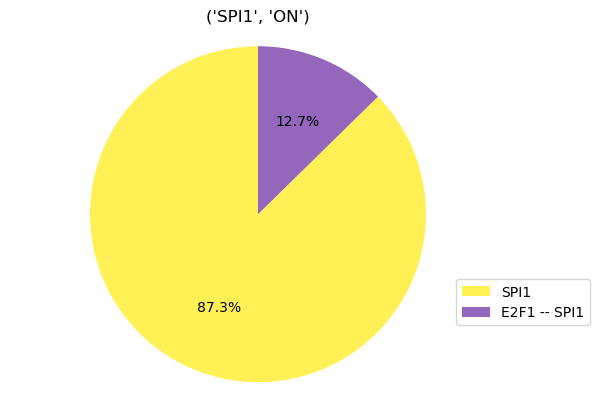

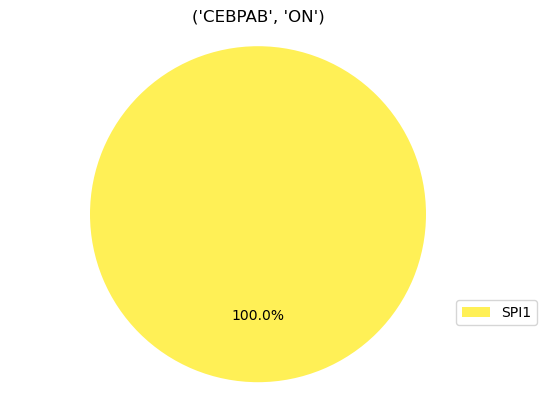

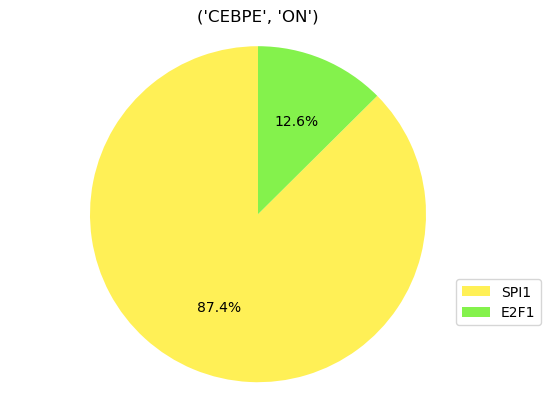

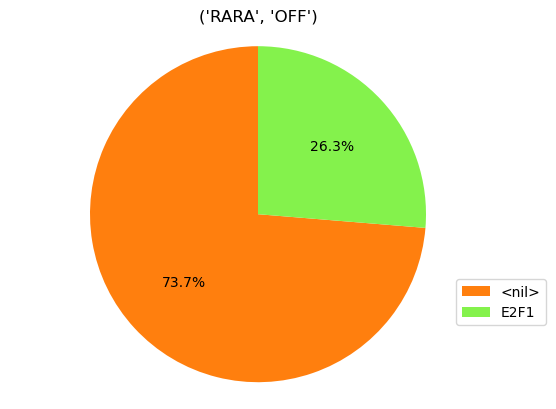

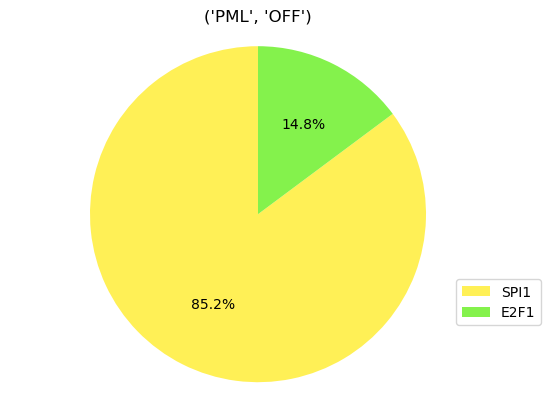

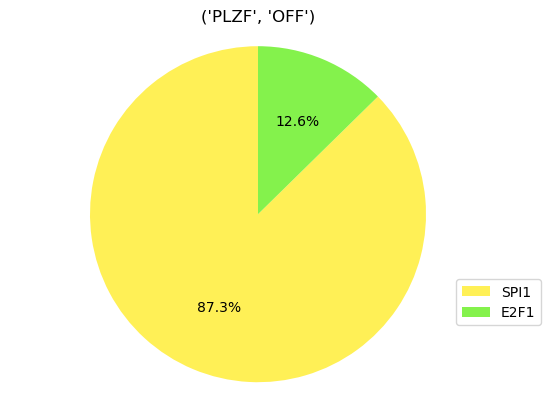

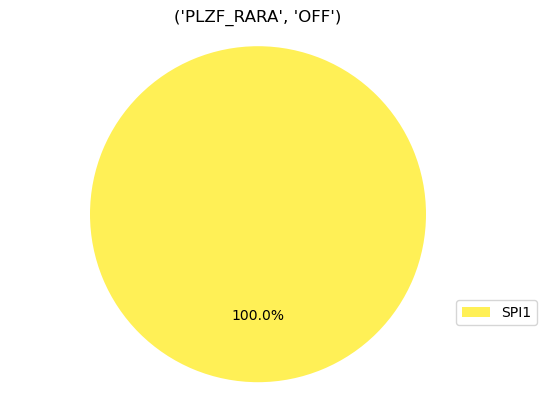

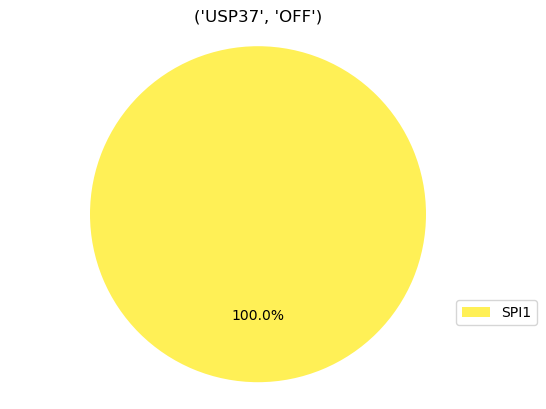

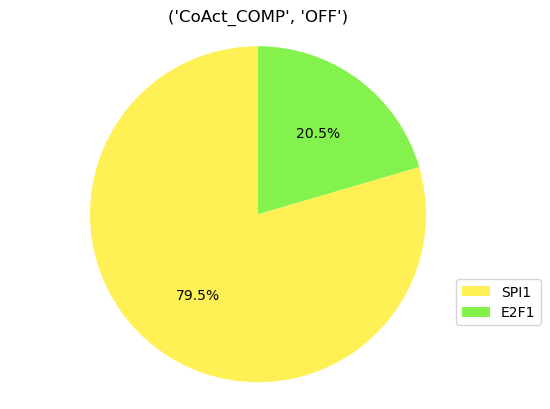

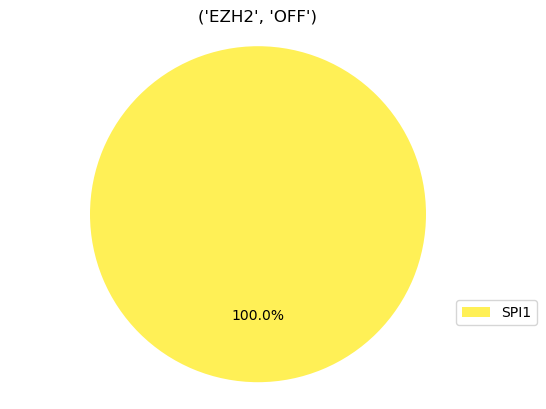

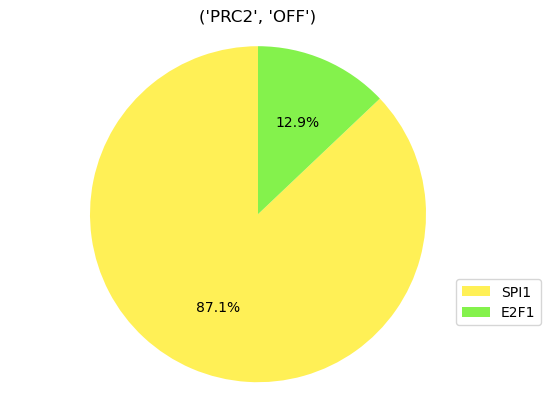

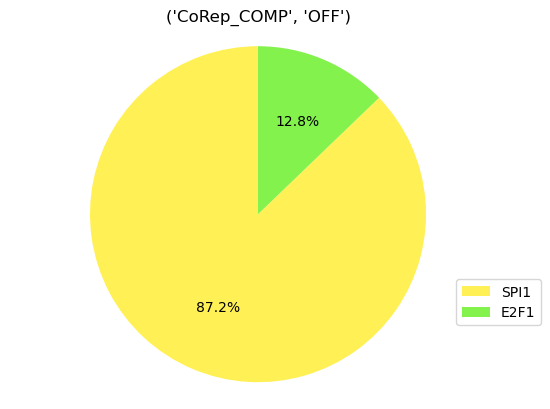

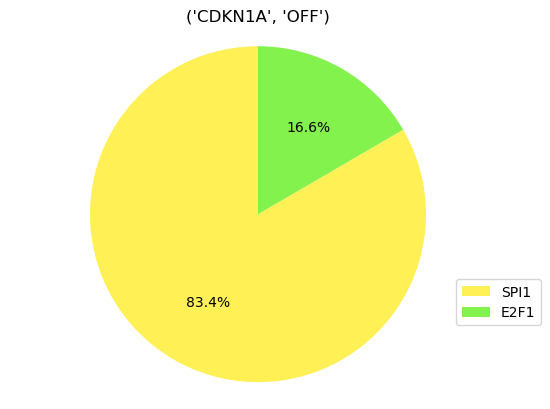

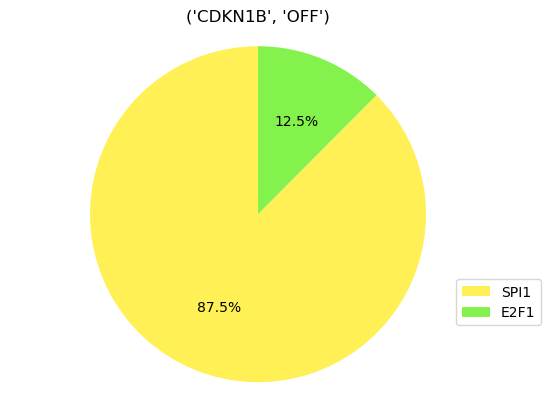

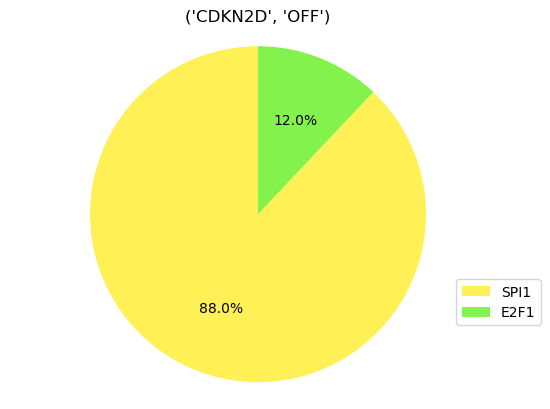

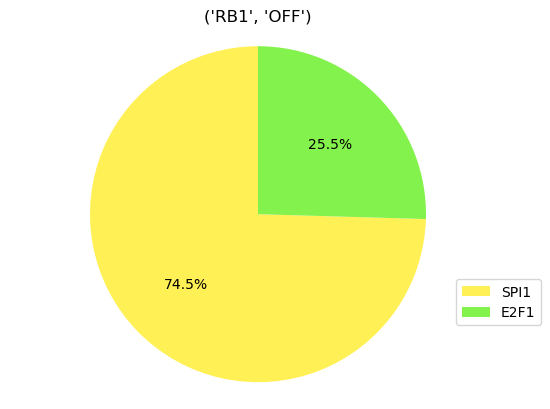

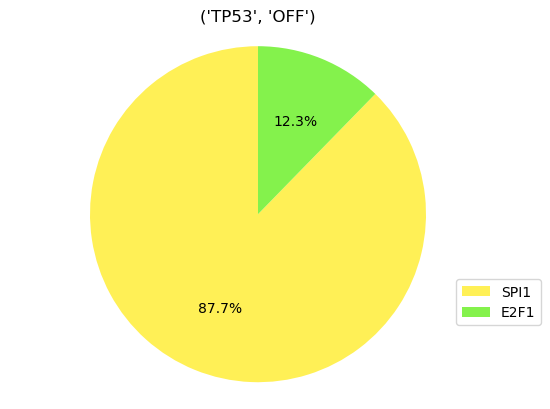

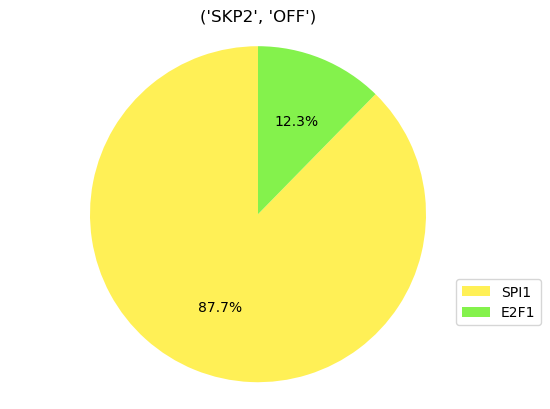

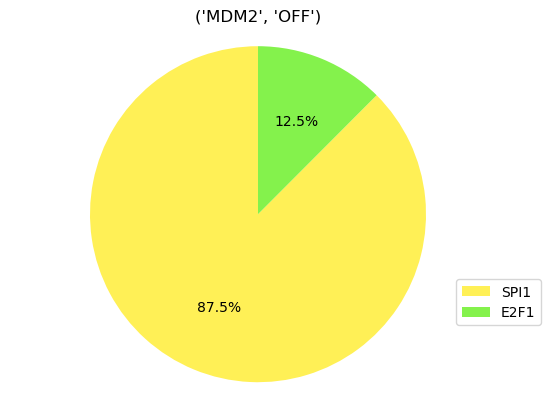

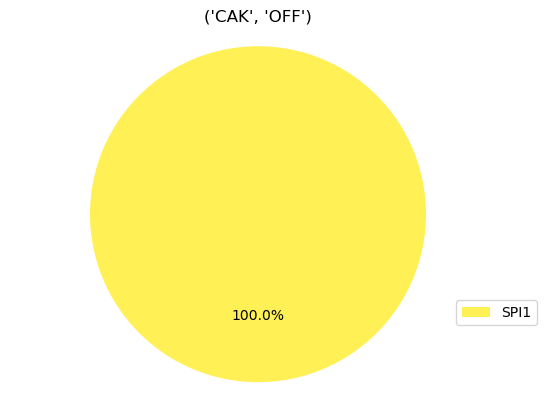

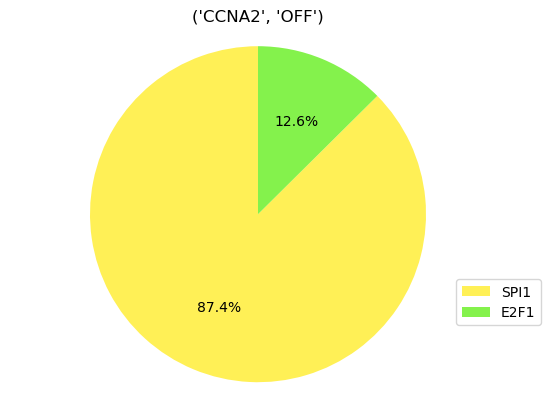

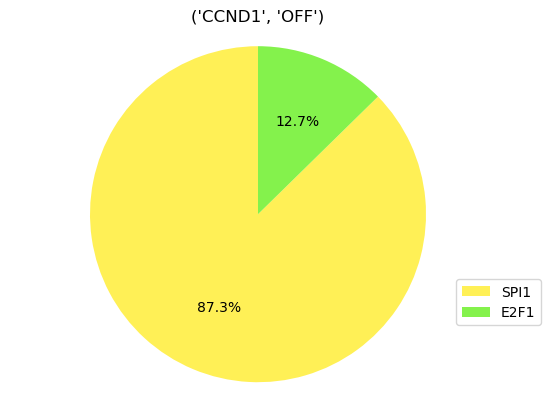

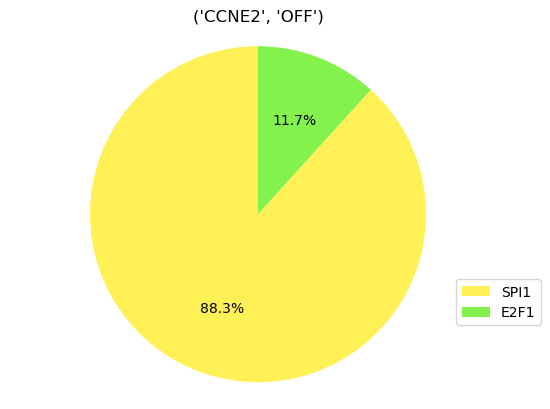

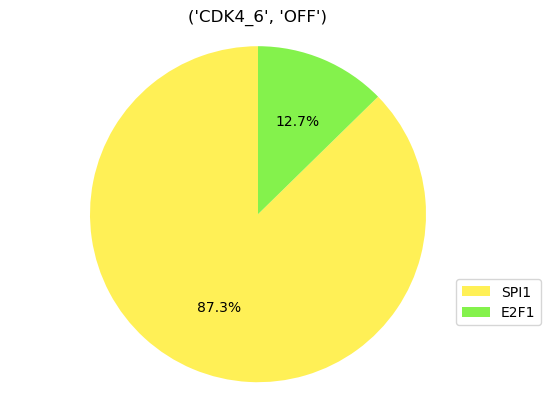

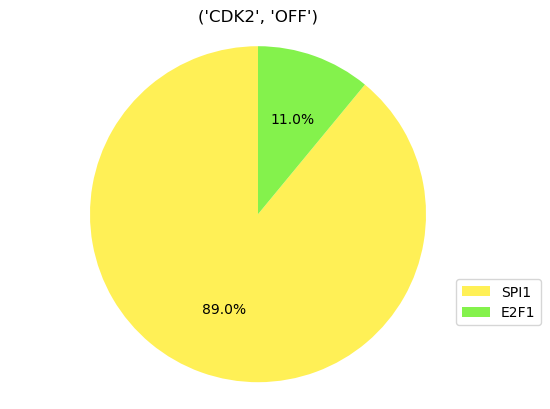

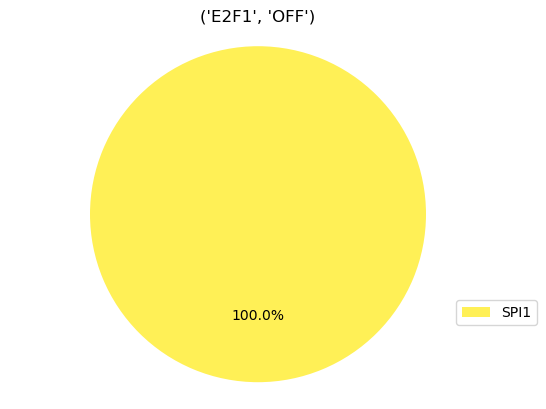

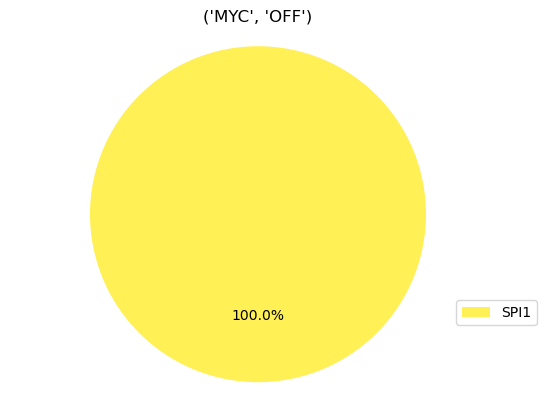

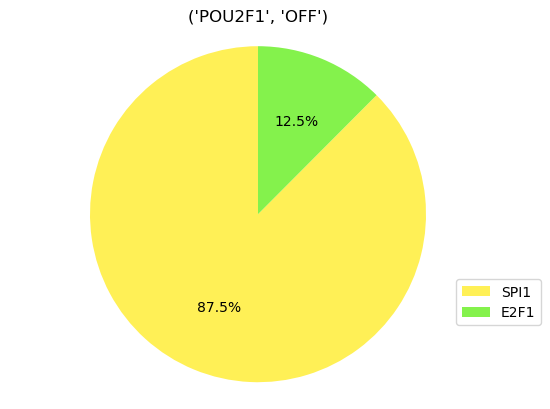

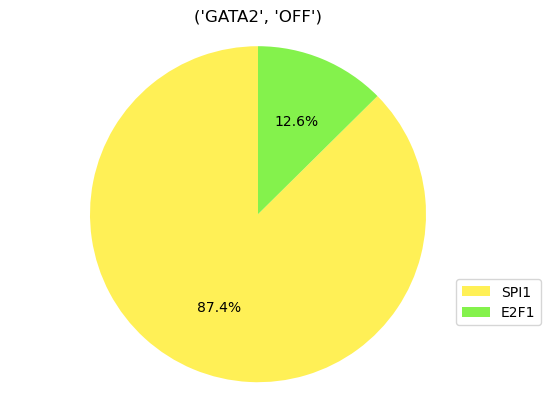

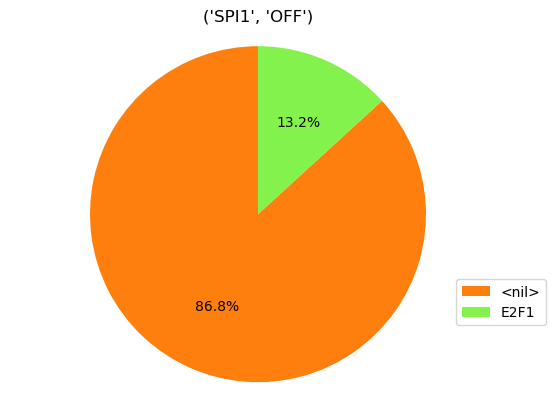

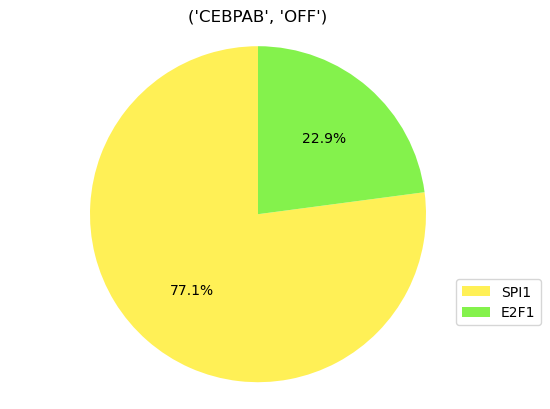

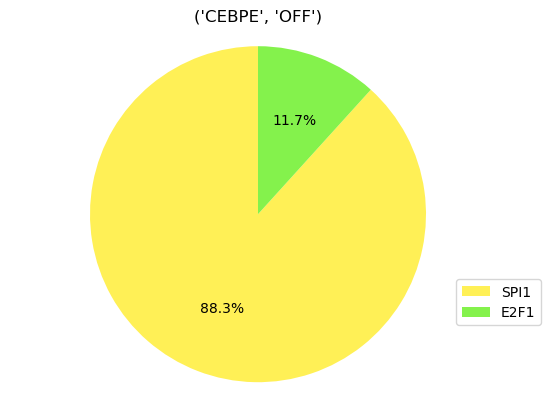

In [15]:
%%time  

# The calculations performed in this cell take around twenty mins on an Apple M1 Pro, 32 GB.
# Comprehensive perturbation analysis with MaBoSS for the identification of nodes affecting the proportions of Differentiation and Proliferation phenotypes.

import matplotlib.pyplot as plt

maboss.set_nodes_istate(maboss_models['No perturbation'], ["RA_b1", "RA_b2", "PLZF_RARAg", "RARA", "PML", "PLZF", "USP37", "CoAct_COMP", "EZH2", "PRC2", "CoRep_COMP", "CDKN2D", "RB1", "SKP2", "MDM2", "CAK", "CCNA2", "CCND1", "CCNE2", "CDK4_6", "CDK2", "E2F1", "MYC", "DUSP6", "POU2F1", "RUNX1", "SPI1", "CEBPAB", "CEBPE"], [0, 1])
maboss_models['No perturbation'].network.set_output(["E2F1", "SPI1"])

sensitivity_analysis_nodes = ['RARA', 'PML','PLZF', 'PLZF_RARA', 'USP37', 'CoAct_COMP', 'EZH2', 'PRC2', 'CoRep_COMP', 'CDKN1A', 'CDKN1B', 'CDKN2D', 'RB1', 'TP53', 'SKP2', 'MDM2', 'CAK', 'CCNA2', 'CCND1', 'CCNE2', 'CDK4_6', 'CDK2', 'E2F1', 'MYC', 'POU2F1', 'GATA2', 'SPI1', 'CEBPAB', 'CEBPE']
sensitivity = maboss.pipelines.simulate_single_mutants(maboss_models['No perturbation'], list_nodes=sensitivity_analysis_nodes, sign='BOTH', cmaboss=False)
for cond in sensitivity:
    sensitivity[cond].plot_piechart()
    plt.title(cond)
    
# activate these lines to plot the trajectories    
    #sensitivity[cond].plot_trajectory()
    #plt.title(cond)
    #sensitivity[cond].plot_node_trajectory()
    #plt.title(cond)

This analysis points to key nodes of the network whose perturbations, i.e. gain-of-function (GOF) or loss-of-function (LOF), affect the probability to reach the differentiated or proliferative attractors.

Perturbations blocking the reachability towards the differentiated attractor:
* PLZF_RARA GOF
* RARA LOF
* SPI1 LOF



Perturbations blocking the reachability towards the proliferative attractor:
* CDKN1A GOF
* CDKN1B GOF
* RB1 GOF
* CEBPAB GOF
* PLZF_RARA LOF
* USP37 LOF
* EZH2 LOF
* CAK LOF
* E2F1 LOF
* MYC LOF

These simulation results are coherent with published experimental observations and point to potential targets for combinatorial therapies.
Tuning of the initial states or of the transition rates used in MaBoSS simulations can be performed to further characterised the potential impacts of selected pertubations in cell fate decisions.

# Parameter sensitivity analysis with MaBoSS

We can further use MaBoSS to perform stochastic simulations considering variations in the activation and deactivation rates of each node.
We use three decreasing and three increasing factors (001, 0.01, 0.1, 1, 10, 100, 1000) for each up and down transition rates of model internal nodes.  
Here also, a state representing the granulocyte-monocyte progenitor stage was used as initial state, with RA set to 2, PLZF_RARAg, RARA, PML, PLZF, USP37, CoAct_COMP, EZH2, PRC2, CoRep_COMP, CDKN2D, RB1, SKP2, MDM2, CAK, CCNA2, CCND1, CCNE2, CDK4_6, CDK2, E2F1, MYC, DUSP6, POU2F1, RUNX1, SPI1, CEBPAB, CEBPE all set to 1, while the rest of the nodes were set to 0.

In [16]:
# Definition of the simulation parameters.
maboss.set_nodes_istate(maboss_models['No perturbation'], ["RA_b1", "RA_b2", "PLZF_RARAg", "RARA", "PML", "PLZF", "USP37", "CoAct_COMP", "EZH2", "PRC2", "CoRep_COMP", "CDKN2D", "RB1", "SKP2", "MDM2", "CAK", "CCNA2", "CCND1", "CCNE2", "CDK4_6", "CDK2", "E2F1", "MYC", "DUSP6", "POU2F1", "RUNX1", "SPI1", "CEBPAB", "CEBPE"], [0, 1])
maboss_models['No perturbation'].network.set_output(["E2F1", "SPI1"])
E2F1='E2F1'
SPI1='SPI1'
maboss_models['No perturbation'].palette[E2F1] = "#84F24C"
maboss_models['No perturbation'].palette[SPI1] = "#FFF056"

# Definition of a long simulation time to allow the system to reach equilibrium.
# maboss_models['No perturbation'].update_parameters(max_time=20000)

# Activate these lines alternatively to get a shorter (faster) simulation    
maboss_models['No perturbation'].update_parameters(max_time=30)


def simulate_single_mutants_rates(model, list_nodes=[], rates=[], directions=[], cmaboss=False):
    """
        Simulates a batch of single mutants in rates and return an array of results

        :param model: the model on which to perform the simulations
        :param list_nodes: the node(s) which are to be mutated (default: all nodes)
        :param rates: which rate mutation to perform. Any list of floats. ([0.001, 0.01, 0.1, 1, 10, 100, 1000] default)
        :param direction: which direction. "up", or "down". ("up" and "down" as default)  
    """ 
    
    if len(list_nodes) == 0:
        list_nodes = list(model.network.keys())
     
    list_single_mutants = []
    default_directions = ['up', 'down']
    default_rates = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if len(rates) == 0:
        rates = default_rates
    if len(directions) ==0:
        directions = default_directions
    for direction in directions:
        for node in list_nodes:
            list_single_mutants += [(node, direction, rate) for rate in rates]

    res = {}
    for single_mutant in list_single_mutants:
        t_model = model.copy()    
        if single_mutant[1]== 'up':
            t_model.param['$u_'+single_mutant[0]] = single_mutant[2]
        if single_mutant[1]== 'down':
            t_model.param['$d_'+single_mutant[0]] = single_mutant[2]
        res.update({single_mutant: t_model.run(cmaboss=cmaboss)})
        
    return res

In [17]:
%%time

# Stochastic simulations with variations in the activation and deactivation rates of each node (excepting input nodes).
# The calculations performed in this cell take around two hours on an Apple M1 Pro, 32 GB.

all_results = simulate_single_mutants_rates(maboss_models['No perturbation'], list_nodes=[], rates=[], cmaboss=False)
all_results

CPU times: user 5.07 s, sys: 4.83 s, total: 9.89 s
Wall time: 1h 46min 29s


{('RA_b1', 'up', 0.001): <maboss.result.Result at 0x2aab749fb250>,
 ('RA_b1', 'up', 0.01): <maboss.result.Result at 0x2aab6bec8b90>,
 ('RA_b1', 'up', 0.1): <maboss.result.Result at 0x2aab742e5450>,
 ('RA_b1', 'up', 1): <maboss.result.Result at 0x2aab7644a7d0>,
 ('RA_b1', 'up', 10): <maboss.result.Result at 0x2aab747de6d0>,
 ('RA_b1', 'up', 100): <maboss.result.Result at 0x2aab76549650>,
 ('RA_b1', 'up', 1000): <maboss.result.Result at 0x2aab74ab5a50>,
 ('RA_b2', 'up', 0.001): <maboss.result.Result at 0x2aab74b40250>,
 ('RA_b2', 'up', 0.01): <maboss.result.Result at 0x2aab742f2d90>,
 ('RA_b2', 'up', 0.1): <maboss.result.Result at 0x2aab742e67d0>,
 ('RA_b2', 'up', 1): <maboss.result.Result at 0x2aab74c53a50>,
 ('RA_b2', 'up', 10): <maboss.result.Result at 0x2aab742e6cd0>,
 ('RA_b2', 'up', 100): <maboss.result.Result at 0x2aab746b4590>,
 ('RA_b2', 'up', 1000): <maboss.result.Result at 0x2aab746974d0>,
 ('PML_RARAg', 'up', 0.001): <maboss.result.Result at 0x2aab74a67310>,
 ('PML_RARAg', 'u

In [18]:
# Transformation of the data structure of the results to build the plots.

import pandas as pd
import numpy as np

# Initialize an empty dictionary to store nested results
nested_res = {}

# Iterate over all_results dictionary and structure the data into nested_res
for (key1, key2, key3), value in all_results.items():
    if key1 not in nested_res:
        nested_res[key1] = {}
    nested_res[key1][(key2, key3)] = value.get_last_nodes_probtraj().iloc[0]['E2F1']

# Convert nested_res dictionary to a DataFrame
PSA_plot_df = pd.DataFrame.from_dict(nested_res, orient='index')

# Transpose the DataFrame to have the desired format
PSA_plot_df = PSA_plot_df.T

# Define the columns to filter. These are the selected nodes for the analysis.
filtered_columns = ['PML', 'PML_RARA', 'PLZF', 'PLZF_RARA', 'USP37', 'CoAct_COMP', 'EZH2', 
                    'PRC2', 'CoRep_COMP', 'CDKN1A', 'CDKN1B', 'CDKN2D', 'RB1', 'TP53', 'SKP2', 
                    'MDM2', 'CAK', 'CCNA2', 'CCND1', 'CCNE2', 'CDK4_6', 'CDK2', 'E2F1', 
                    'MYC', 'POU2F1', 'GATA2', 'SPI1', 'CEBPAB']

# Filter the DataFrame to include only the specified columns
PSA_plot_df_filtered = PSA_plot_df[filtered_columns]

# Display the filtered DataFrame
PSA_plot_df_filtered


PML  PML_RARA    PLZF  PLZF_RARA   USP37  CoAct_COMP  \
up   0.001     0.1233    0.1220  0.1261     0.0001  0.1000      0.1272   
     0.010     0.1297    0.1222  0.1298     0.0020  0.1003      0.1265   
     0.100     0.1236    0.1299  0.1223     0.0196  0.1072      0.1281   
     1.000     0.1264    0.1305  0.1216     0.1213  0.1207      0.1227   
     10.000    0.1245    0.1236  0.1302     0.2627  0.1368      0.1182   
     100.000   0.1266    0.1214  0.1265     0.2878  0.1510      0.1250   
     1000.000  0.1245    0.1225  0.1281     0.2887  0.1502      0.1236   
down 0.001     0.1096    0.1300  0.1251     0.1688  0.1858      0.1244   
     0.010     0.1192    0.1299  0.1200     0.1709  0.1887      0.1274   
     0.100     0.1131    0.1257  0.1239     0.1609  0.1804      0.1283   
     1.000     0.1259    0.1217  0.1306     0.1213  0.1257      0.1270   
     10.000    0.1375    0.1212  0.1291     0.1131  0.0530      0.1223   
     100.000   0.1403    0.1228  0.1289     0.1040  0.0361      0.1271   
     1000.000  0.1425    0.1242  0.1257     0.1105  0.0343      0.1264   

                 EZH2    PRC2  CoRep_COMP  CDKN1A  CDKN1B  CDKN2D     RB1  \
up   0.001     0.1266  0.1265      0.1268  0.1681  0.1261  0.1197  0.1278   
     0.010     0.1202  0.1278      0.1239  0.1604  0.1243  0.1289  0.1249   
     0.100     0.1252  0.1265      0.1204  0.1571  0.1252  0.1241  0.1239   
     1.000     0.1262  0.1263      0.1282  0.1221  0.1233  0.1277  0.1279   
     10.000    0.1268  0.1213      0.1305  0.0816  0.1231  0.1274  0.1221   
     100.000   0.1276  0.1238      0.1252  0.0744  0.1241  0.1230  0.1217   
     1000.000  0.1239  0.1221      0.1292  0.0764  0.1206  0.1256  0.1298   
down 0.001     0.1262  0.1289      0.1229  0.0992  0.1226  0.1243  0.0003   
     0.010     0.1289  0.1274      0.1267  0.0953  0.1296  0.1242  0.0029   
     0.100     0.1258  0.1280      0.1234  0.0998  0.1201  0.1261  0.0204   
     1.000     0.1291  0.1316      0.1273  0.1258  0.1277  0.1285  0.1286   
     10.000    0.1229  0.1271      0.1266  0.1391  0.1290  0.1289  0.2323   
     100.000   0.1218  0.1315      0.1302  0.1469  0.1283  0.1192  0.2522   
     1000.000  0.1194  0.1252      0.1195  0.1374  0.1261  0.1186  0.2523   

                 TP53    SKP2    MDM2     CAK   CCNA2   CCND1   CCNE2  CDK4_6  \
up   0.001     0.1320  0.1295  0.1169  0.1198  0.1243  0.1246  0.1325  0.1287   
     0.010     0.1201  0.1253  0.1271  0.1159  0.1201  0.1244  0.1232  0.1239   
     0.100     0.1207  0.1237  0.1218  0.1200  0.1270  0.1240  0.1204  0.1264   
     1.000     0.1204  0.1219  0.1249  0.1253  0.1237  0.1253  0.1249  0.1267   
     10.000    0.1244  0.1214  0.1250  0.1343  0.1247  0.1240  0.1311  0.1203   
     100.000   0.1244  0.1240  0.1253  0.1286  0.1283  0.1247  0.1203  0.1213   
     1000.000  0.1297  0.1258  0.1198  0.1283  0.1273  0.1282  0.1270  0.1263   
down 0.001     0.1262  0.1223  0.1217  0.1519  0.1246  0.1271  0.1269  0.1234   
     0.010     0.1225  0.1304  0.1239  0.1648  0.1198  0.1241  0.1251  0.1225   
     0.100     0.1262  0.1271  0.1292  0.1465  0.1214  0.1310  0.1219  0.1287   
     1.000     0.1282  0.1223  0.1316  0.1264  0.1220  0.1260  0.1280  0.1246   
     10.000    0.1256  0.1197  0.1187  0.1096  0.1169  0.1226  0.1265  0.1297   
     100.000   0.1225  0.1267  0.1222  0.1076  0.1246  0.1259  0.1221  0.1295   
     1000.000  0.1333  0.1217  0.1172  0.1061  0.1319  0.1209  0.1283  0.1232   

                 CDK2      E2F1     MYC  POU2F1   GATA2    SPI1  CEBPAB  
up   0.001     0.1263  0.105300  0.0960  0.1240  0.1199  0.1205  0.1326  
     0.010     0.1197  0.104000  0.1003  0.1279  0.1243  0.1262  0.1240  
     0.100     0.1236  0.110200  0.1048  0.1265  0.1252  0.1214  0.1334  
     1.000     0.1274  0.126600  0.1175  0.1272  0.1244  0.1259  0.1271  
     10.000    0.1261  0.143300  0.1601  0.1215  0.1210  0.1235  0.1229  
     100.000   0.1275  0.143000  0.1642  0.1220  0.1332  0.1259  0.1201  
     1000.000  0.

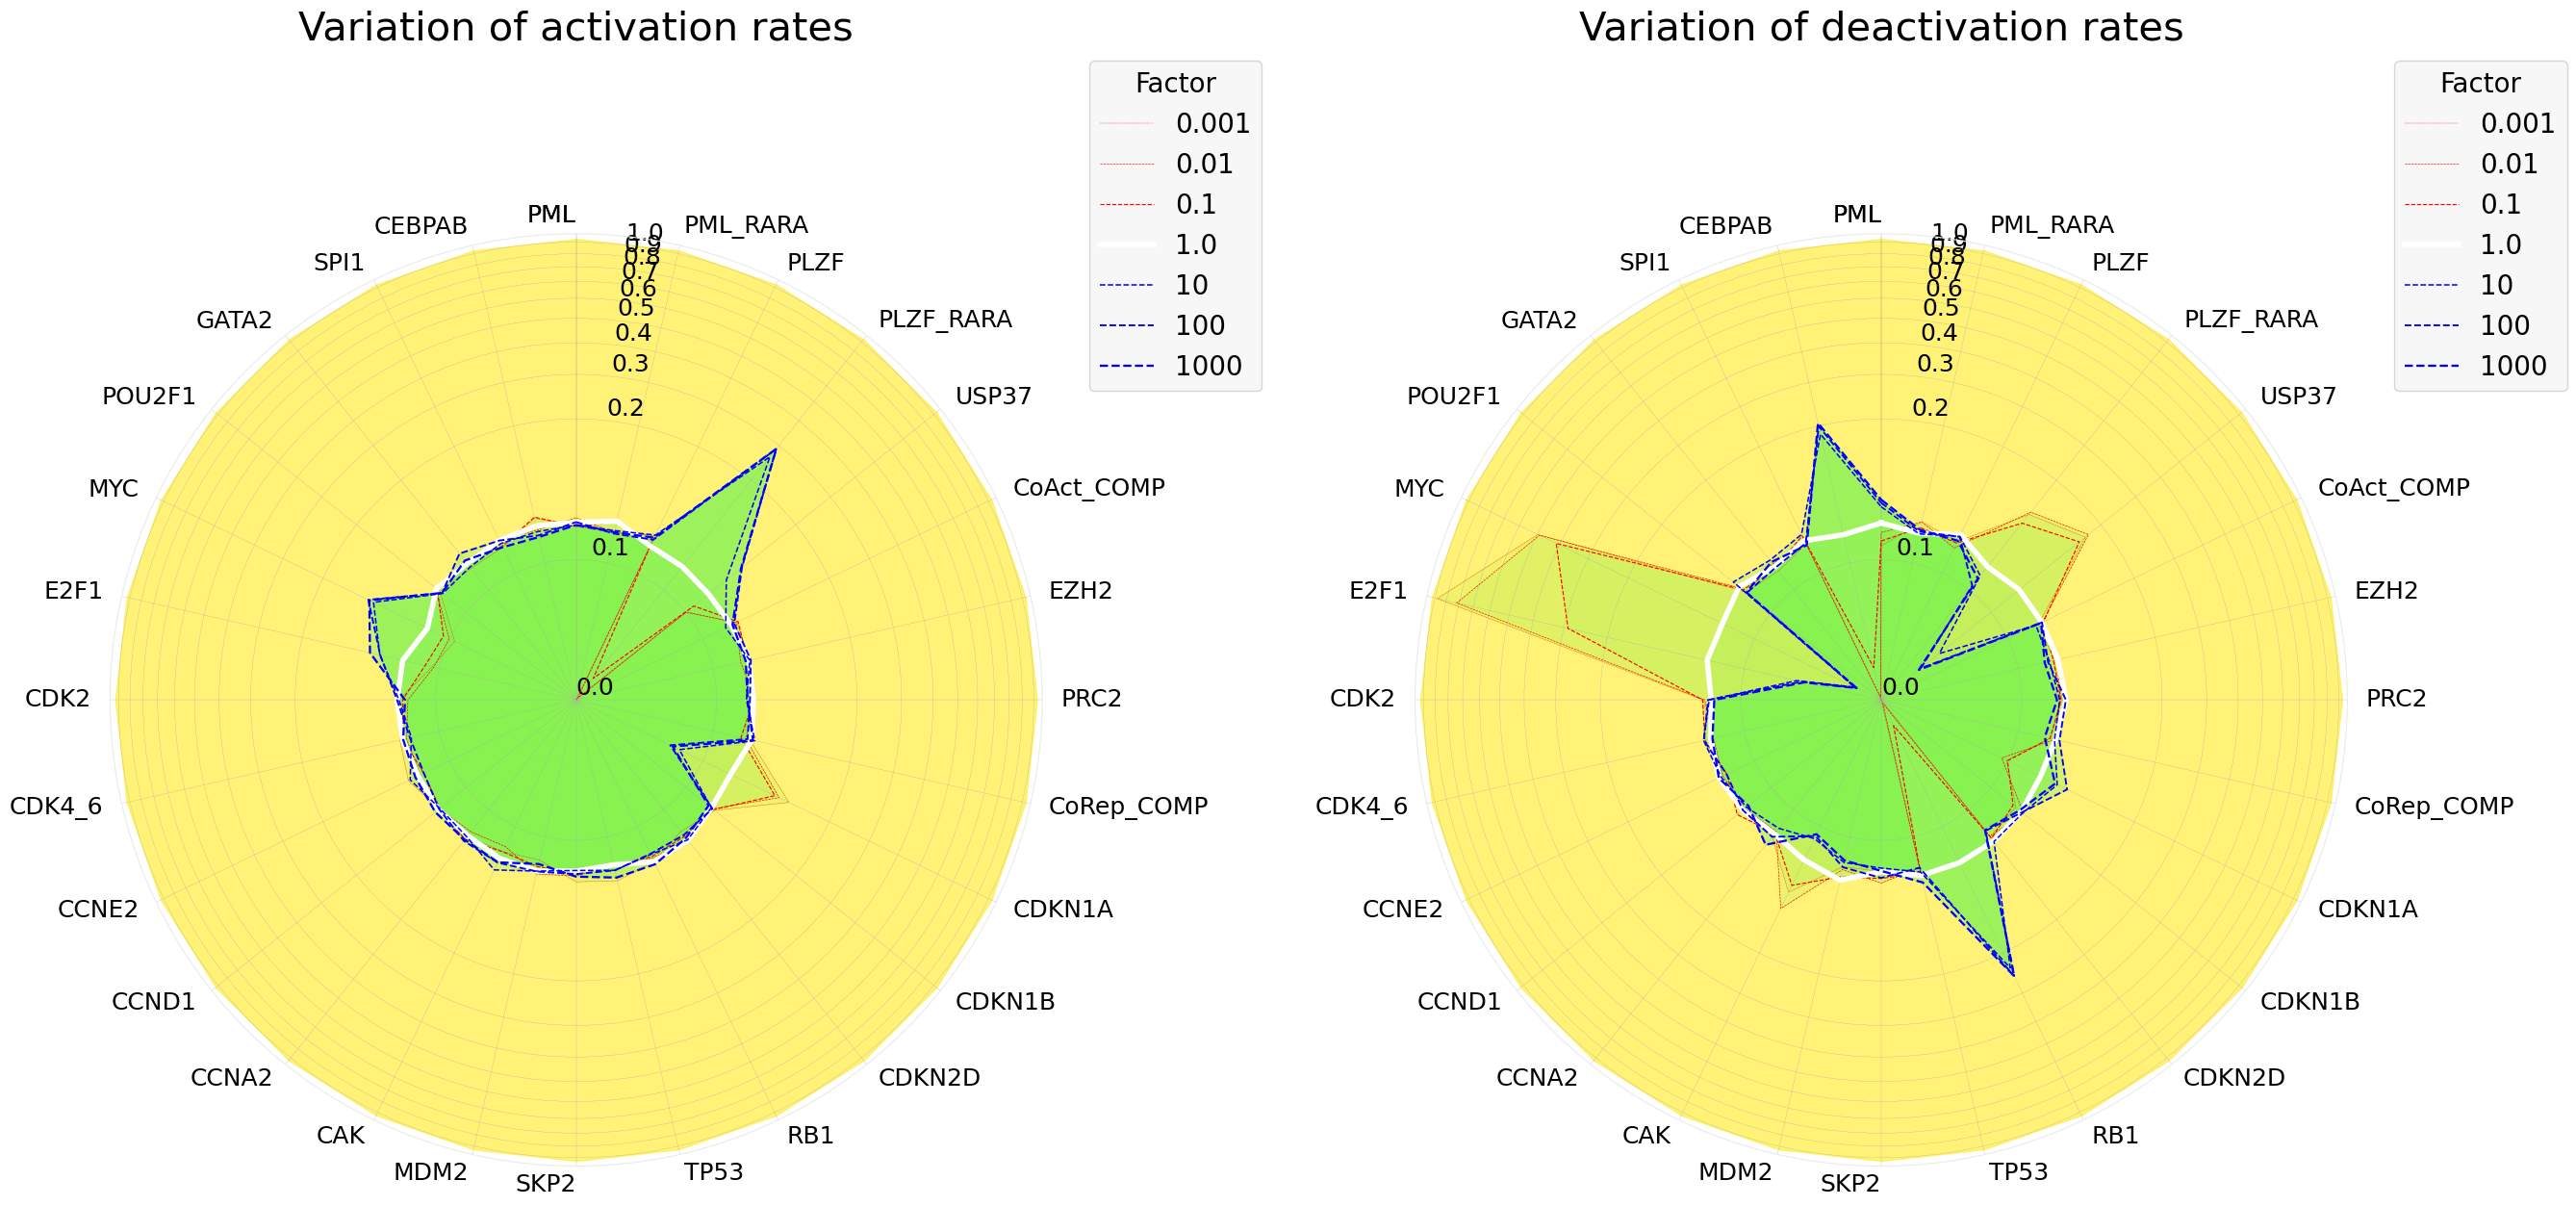

In [19]:
# Plot the impact of all parameter changes in a pair of polar plots.

from matplotlib.ticker import FixedLocator, FixedFormatter

cat = list(PSA_plot_df_filtered.columns)
cat = [*cat, cat[0]] #to close the radar, duplicate the first column
n_points = len(cat)

#As we have n categories the radar chart shoud have n radial axis
#angles need to be converted to radian so we multiply by 2*pi and create the list of angles:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cat))


fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), facecolor="white", figsize=(30, 30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

for index, row in PSA_plot_df_filtered.iterrows():
    if 'up' in index:
        ax1.fill(label_loc, [*row.tolist(), row.tolist()[0]], alpha=0.4, color='#84F24C')
        ax1.fill_between(label_loc, [*row.tolist(), row.tolist()[0]], PSA_plot_df_filtered.max().max()*1.05, alpha=0.2, color='#FFF055')
        
        if index[1]==1:
            ax1.plot(label_loc, [*row.tolist(), row.tolist()[0]], '-', color='white', label=index[1], linewidth=4)
        elif index[1]>1:
            ax1.plot(label_loc, [*row.tolist(), row.tolist()[0]], '--', color='blue', label='{:.0f}'.format(index[1]), linewidth=0.91*(index[1]**0.086))
        elif index[1]<1:
            ax1.plot(label_loc, [*row.tolist(), row.tolist()[0]], '--', color='red', label=index[1], linewidth=1.54*(index[1]**0.266))

    if 'down' in index:
        ax2.fill(label_loc, [*row.tolist(), row.tolist()[0]], alpha=0.4, color='#84F24C')
        ax2.fill_between(label_loc, [*row.tolist(), row.tolist()[0]], PSA_plot_df_filtered.max().max()*1.05, alpha=0.2, color='#FFF055')
        
        if index[1]==1:
            ax2.plot(label_loc, [*row.tolist(), row.tolist()[0]], '-', color='white', label=index[1], linewidth=4)
        elif index[1]>1:
            ax2.plot(label_loc, [*row.tolist(), row.tolist()[0]], '--', color='blue', label='{:.0f}'.format(index[1]), linewidth=0.91*(index[1]**0.086))
        elif index[1]<1:
            ax2.plot(label_loc, [*row.tolist(), row.tolist()[0]], '--', color='red', label=index[1], linewidth=1.54*(index[1]**0.266))

#Set titles.
ax1.set_title('Variation of activation rates', y=1.2, fontsize=30)
ax2.set_title('Variation of deactivation rates', y=1.2, fontsize=30)

#Setting of collective visual properties.
for ax in [ax1, ax2]:

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    #Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(label_loc), cat)

    # Go through labels and adjust alignment based on where it is in the circle.
    #for ax in [ax1, ax2]:
    for label, angle in zip(ax.get_xticklabels(), label_loc):
        # if angle in (0, np.pi):
        #label.set_horizontalalignment('center')
        if 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
   
    #Set symlog scale
    ax.set_yscale('symlog', linthresh=0.2)
    
    range_yvalues = np.arange(0, PSA_plot_df_filtered.max().max()*1.05, 0.1)
    ax.set_rgrids(range_yvalues)
    ax.yaxis.set_major_locator(FixedLocator(range_yvalues))
    ax.yaxis.set_major_formatter(FixedFormatter([f'{val:.1f}' for val in range_yvalues]))
    
    # Set position of y-labels (0-100) to be in the middle of the first two axes.
    ax.set_rlabel_position(180 / n_points)
    #Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=15)    
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA', linewidth=0.2)
    #Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#eaeaea')
    
    # Add legend.
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.2), fontsize=20, title='Factor', title_fontsize=20, facecolor='#F5F5F5')
    #Make the y-axis (0-100) labels smaller.
    ax.tick_params(labelsize=18)


The resulting polar plots display the impact of the variations of the activation (left) and deactivation (right) rates for the model nodes, excepting input and output nodes, onto the probability to reach the proliferative (green area) versus differentiated (yellow area) attractor. 
The initial state representing GMP cells was selected to perform stochastic simulations under variations of the activation or inactivation transition rates for each node, each time multiplying one of them by one of the following factors: 0.001, 0.01, 0.1, 1, 10, 100, 1,000
The probability (between 0 and 1) of the proliferative attractor for each condition is plotted as a vertex of a polygon (one for each rate variant). 
The polygon corresponding to the default transition rates (set to 1) is displayed in white. 
The blue polygons correspond to transition rates higher than the default, whereas the red polygons correspond to transition rates lower than the default. 
For example, decreasing the activation rate or increasing the deactivation rate of the node MYC reduces the probability to reach the proliferative attractor. 
These simulation thereby point to potential targets for combinatorial therapies to treat APL.

/tmp/ipykernel_450/803949938.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(figsize=(10,5))


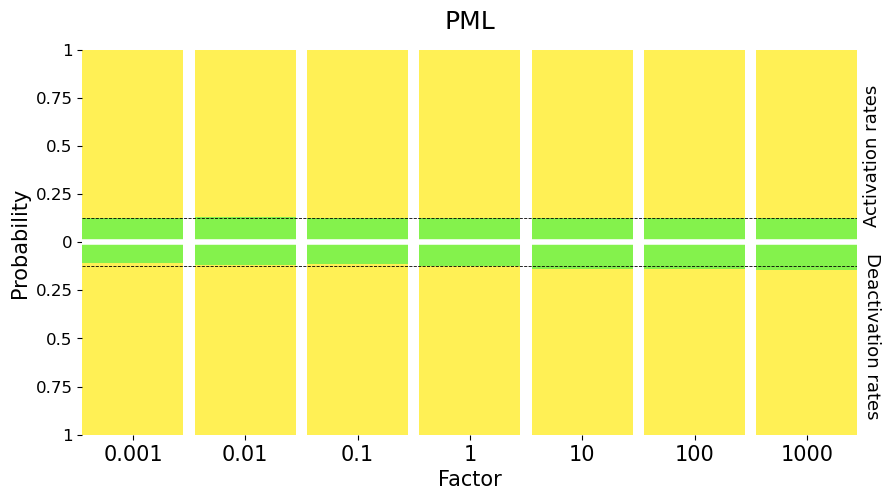

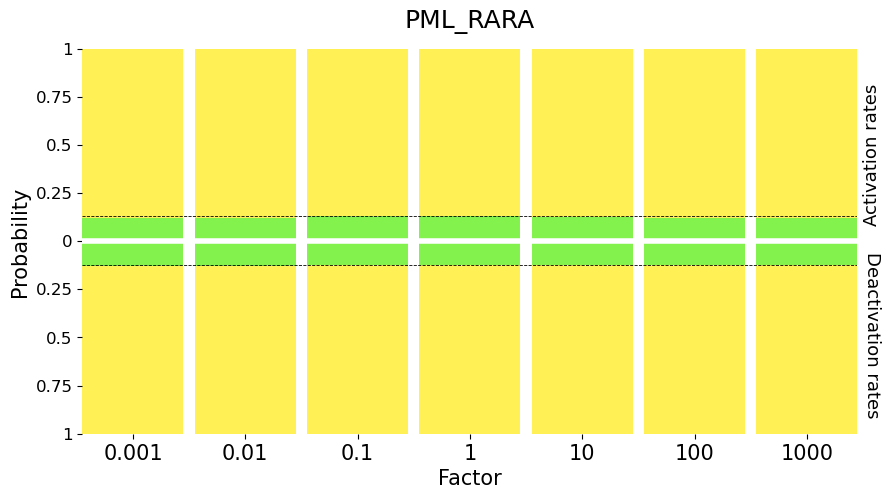

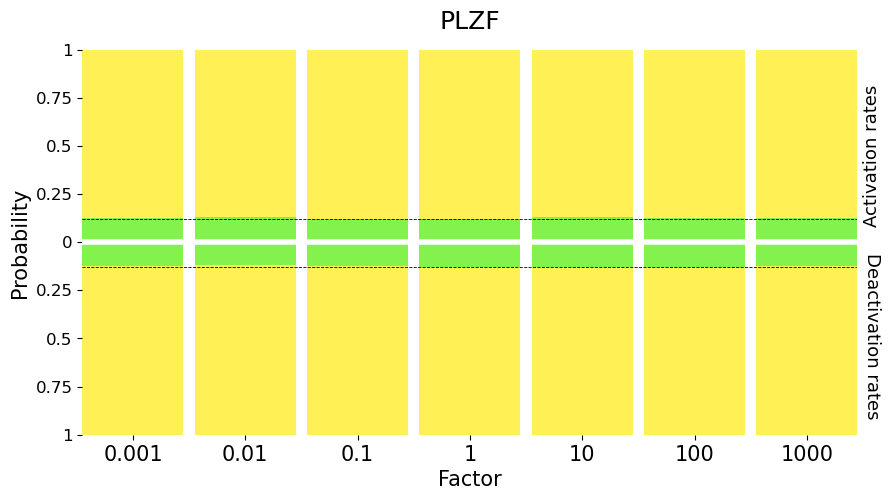

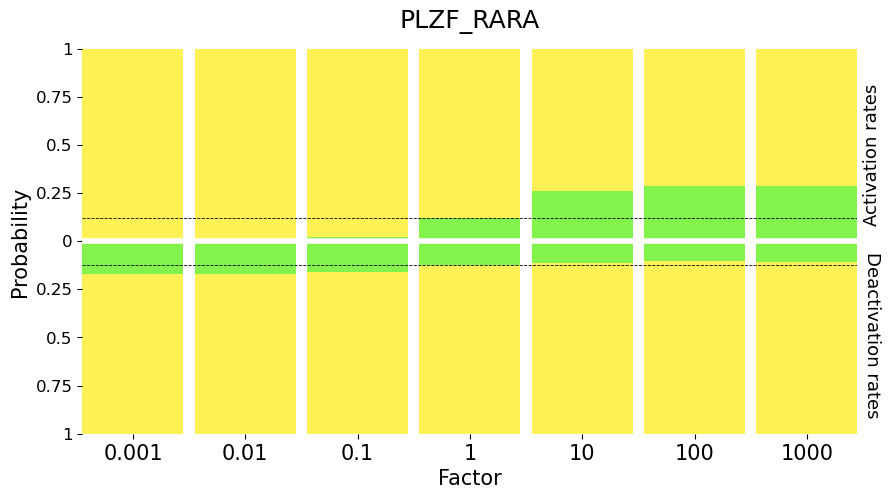

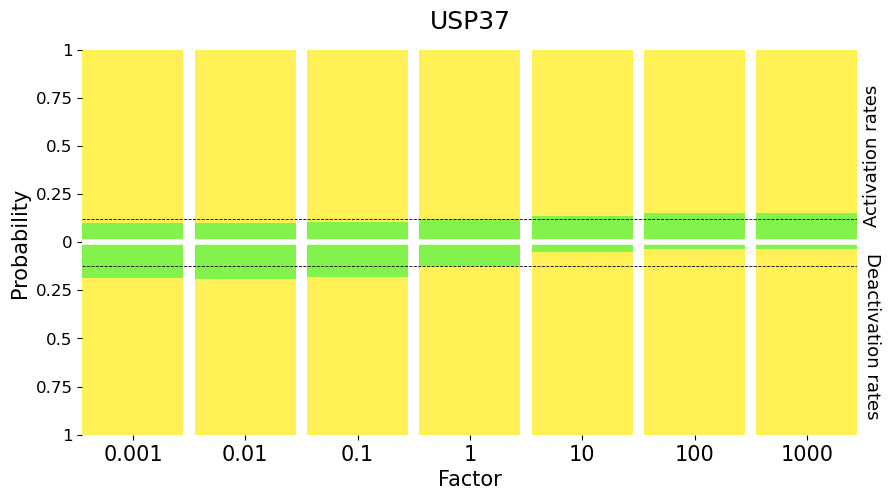

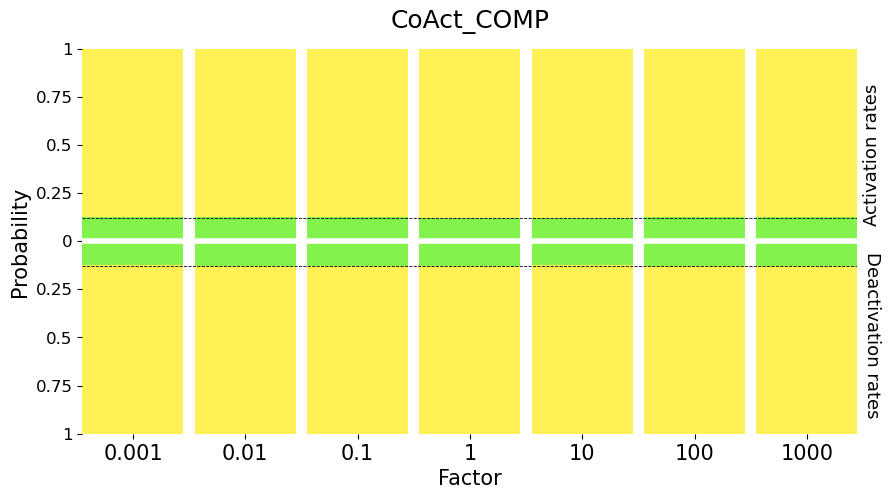

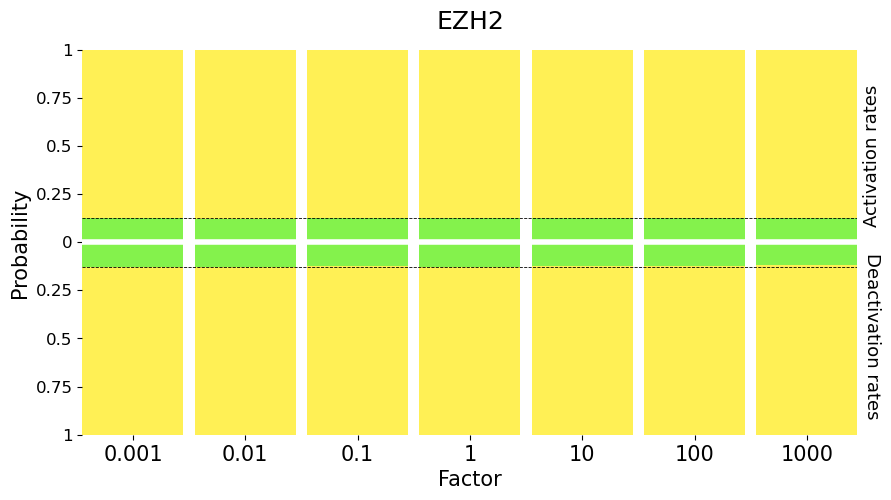

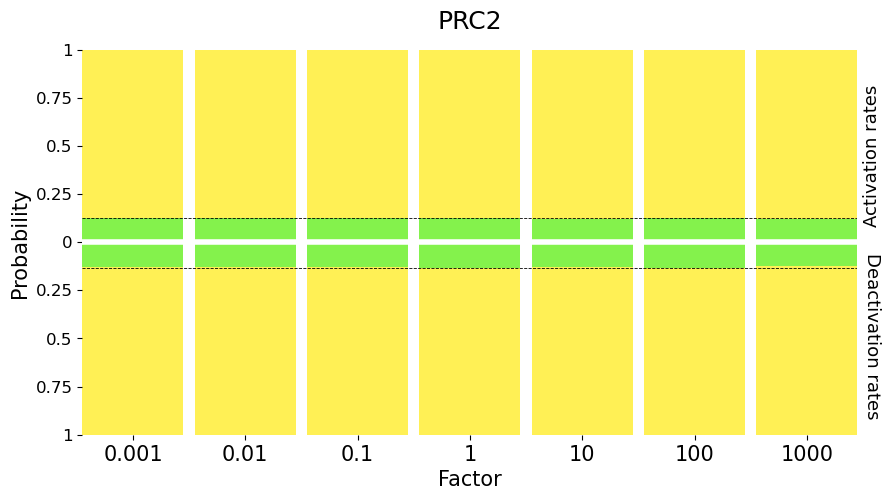

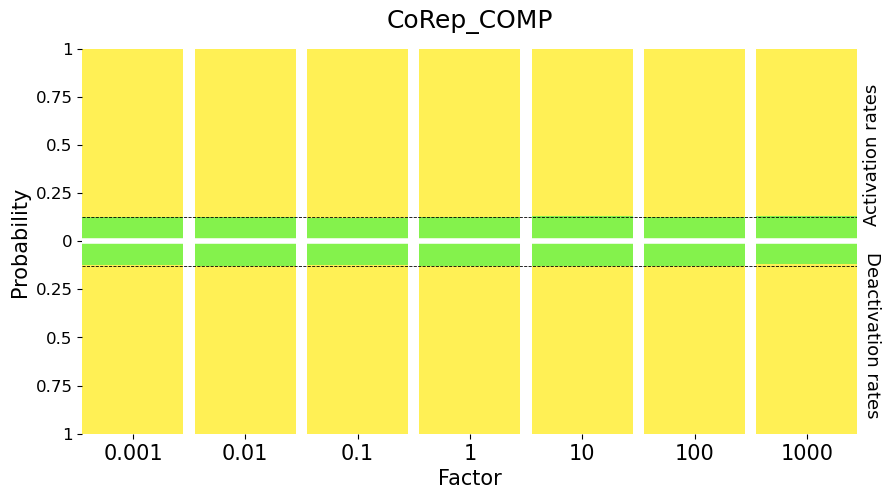

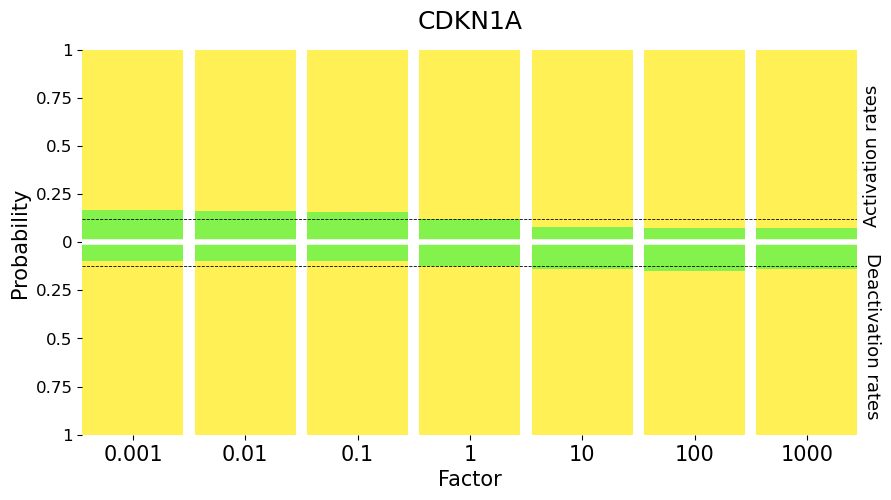

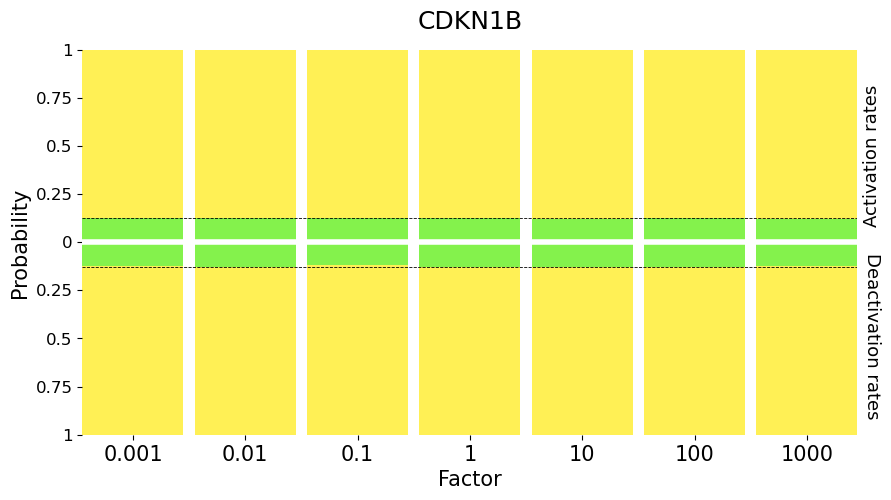

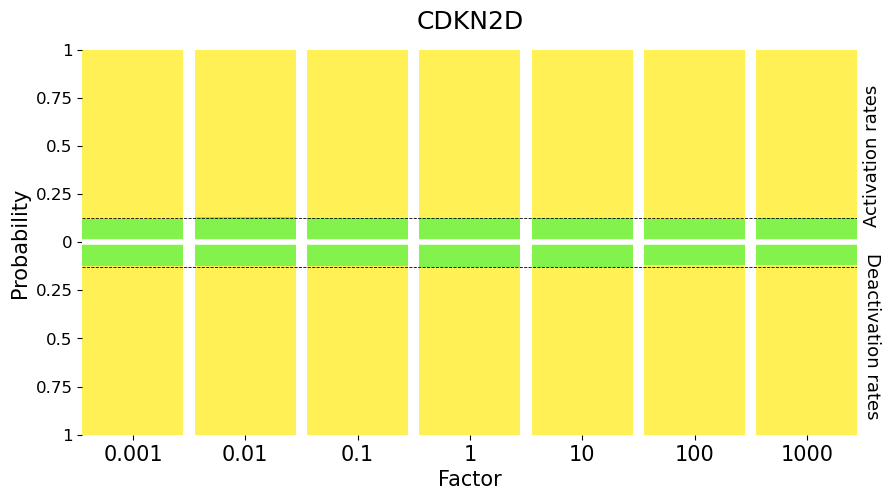

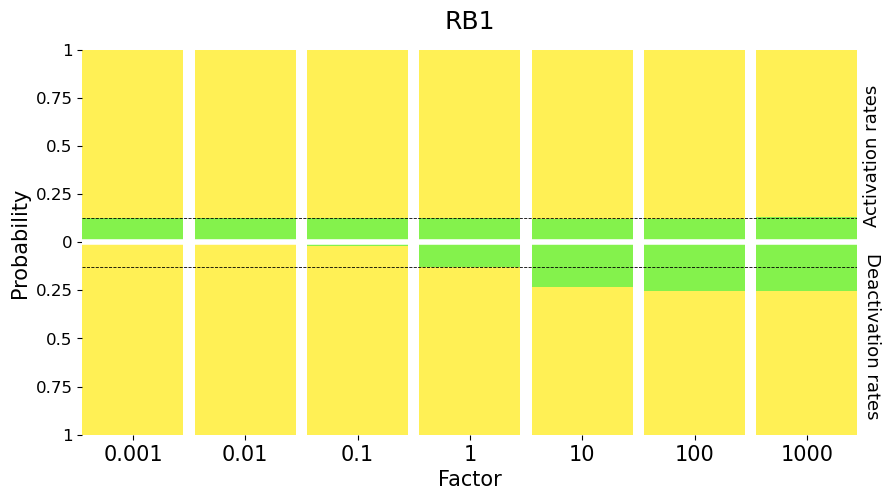

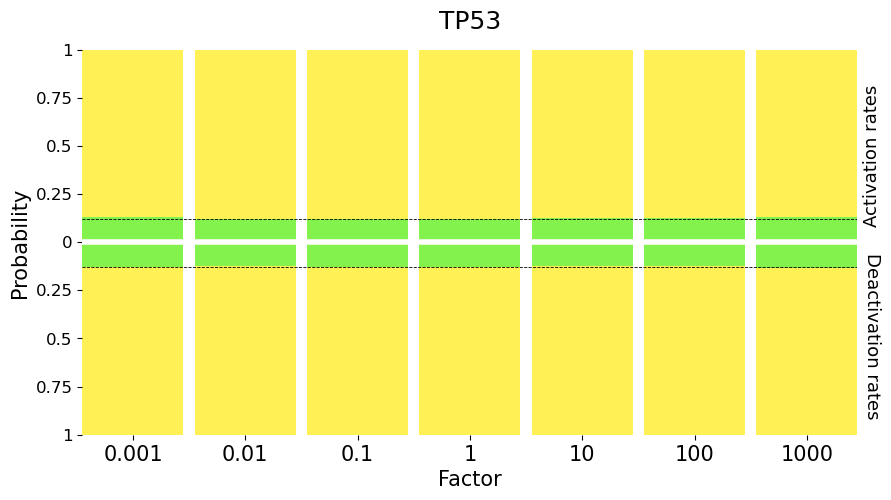

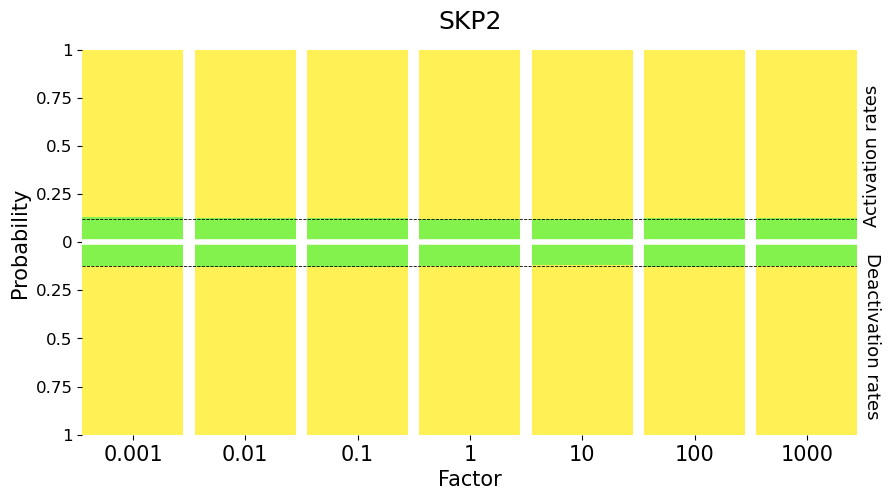

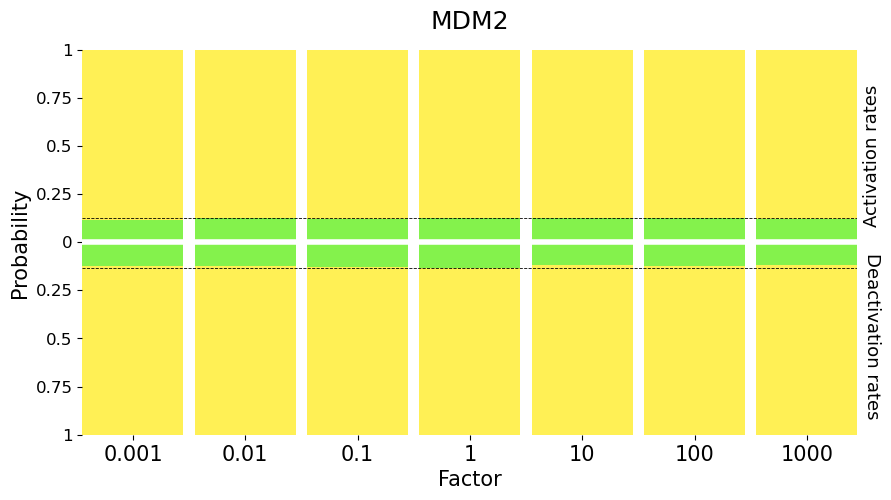

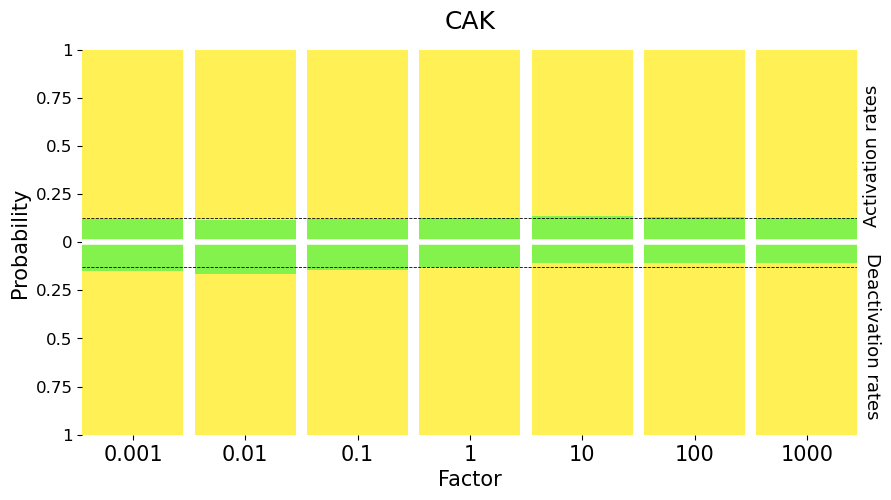

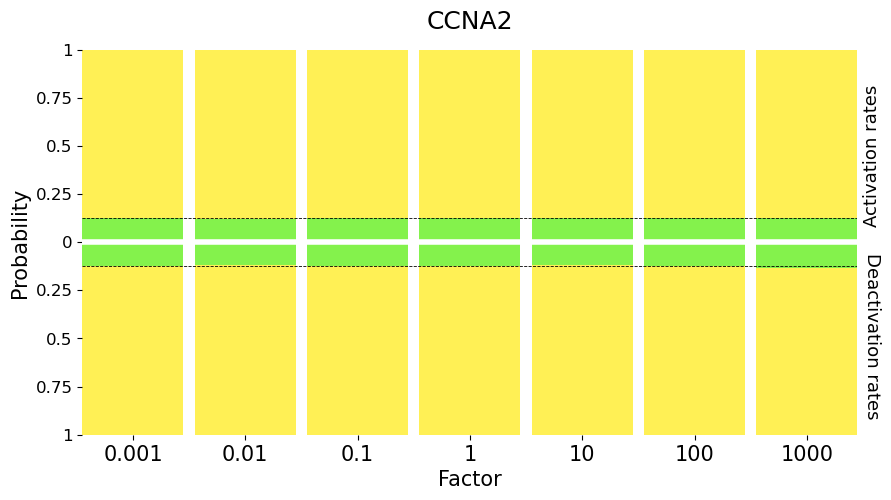

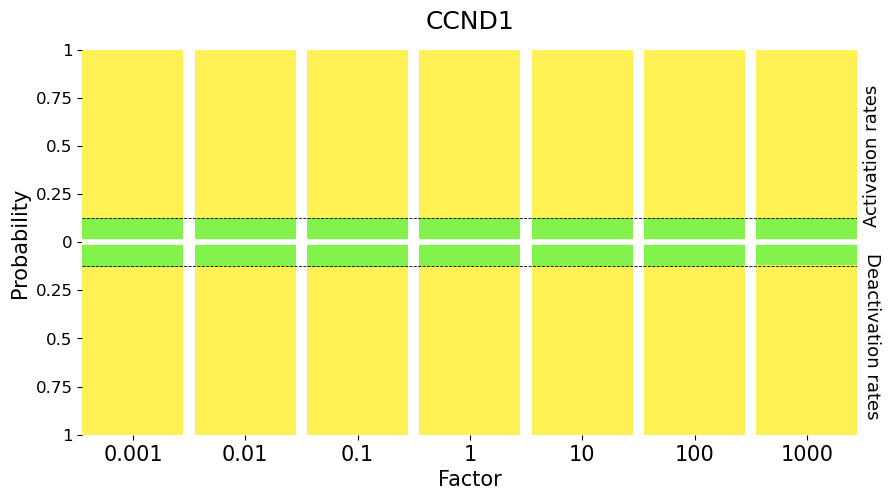

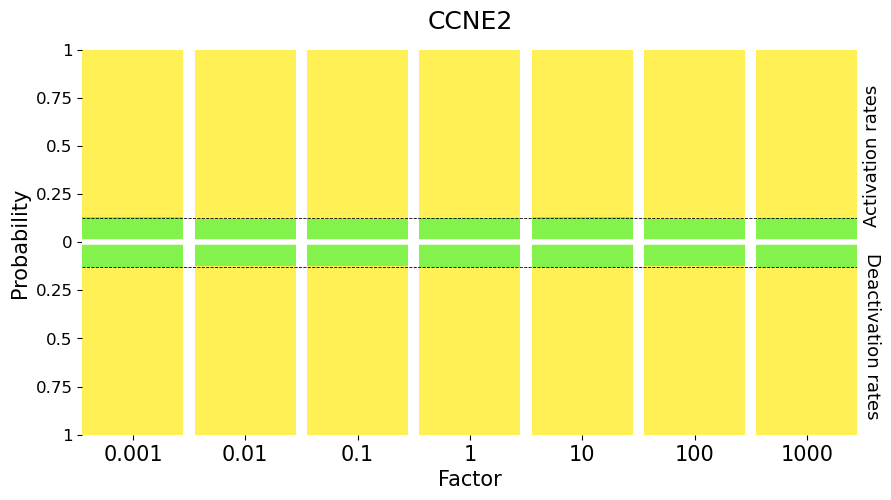

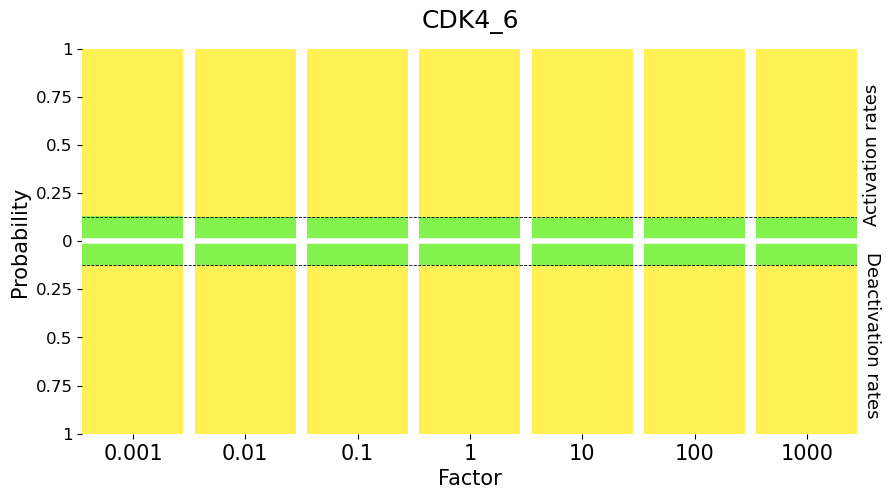

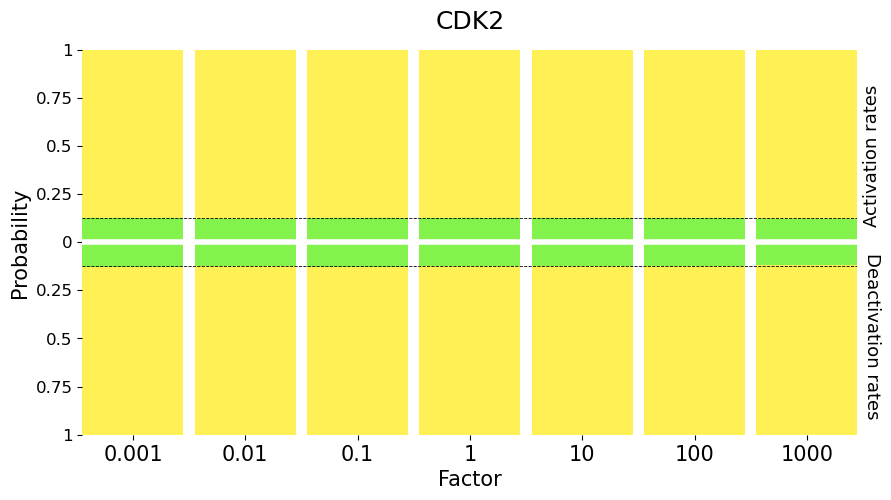

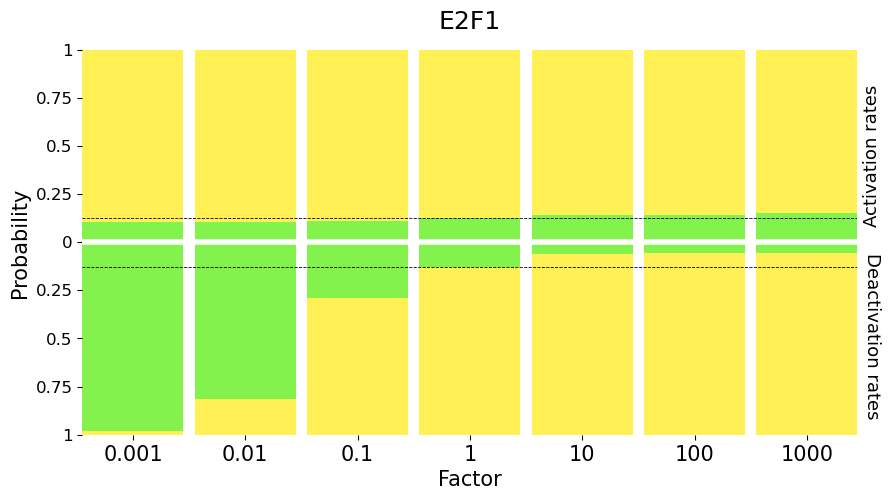

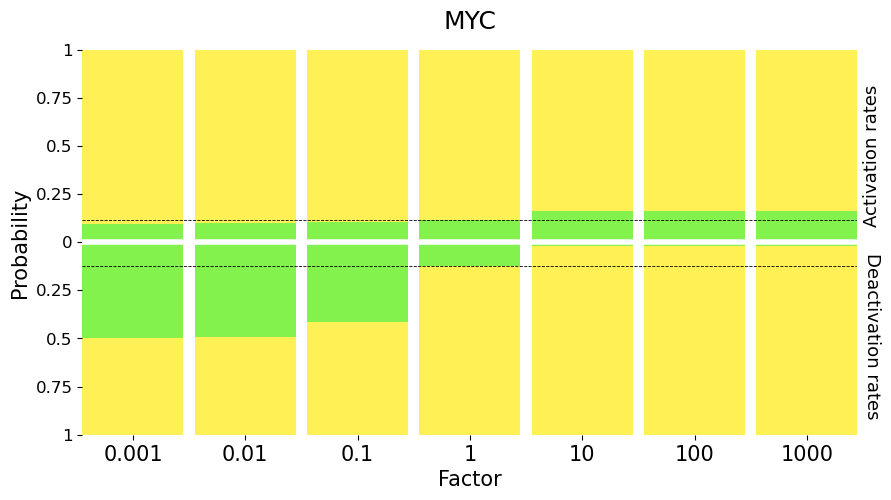

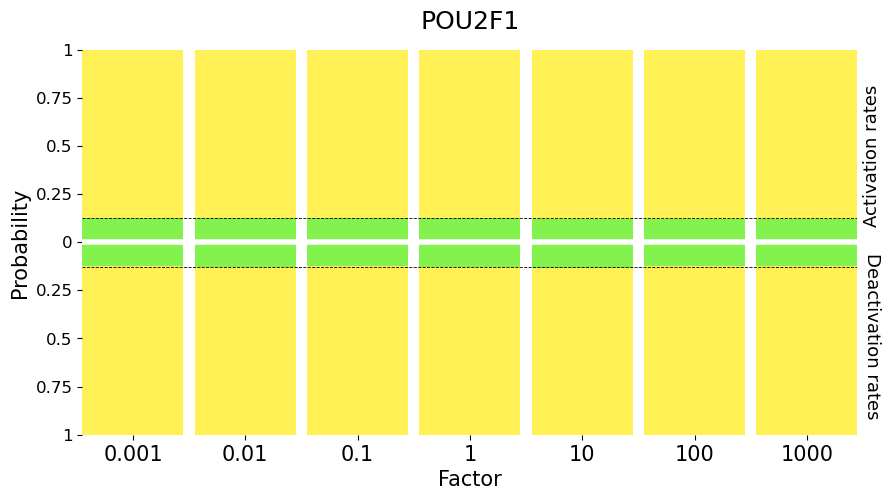

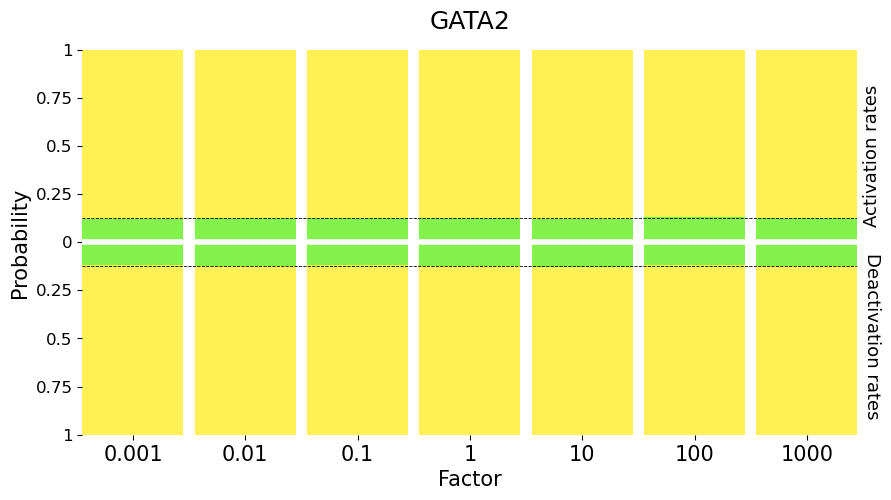

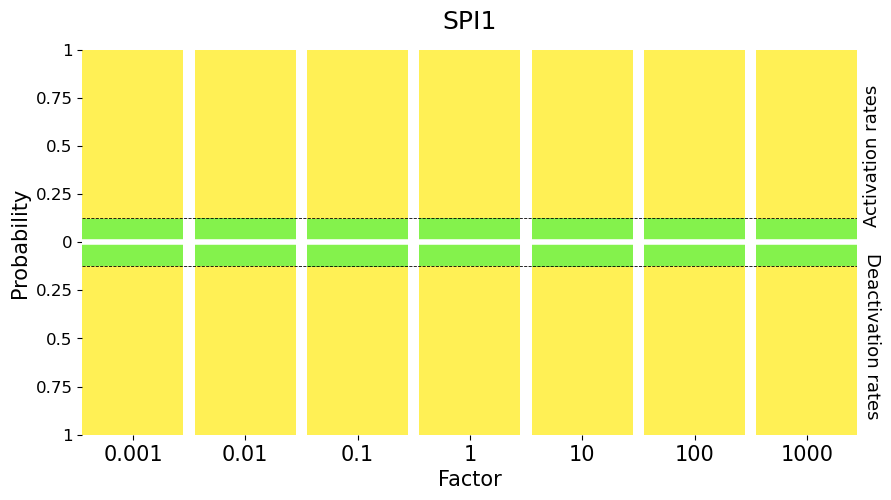

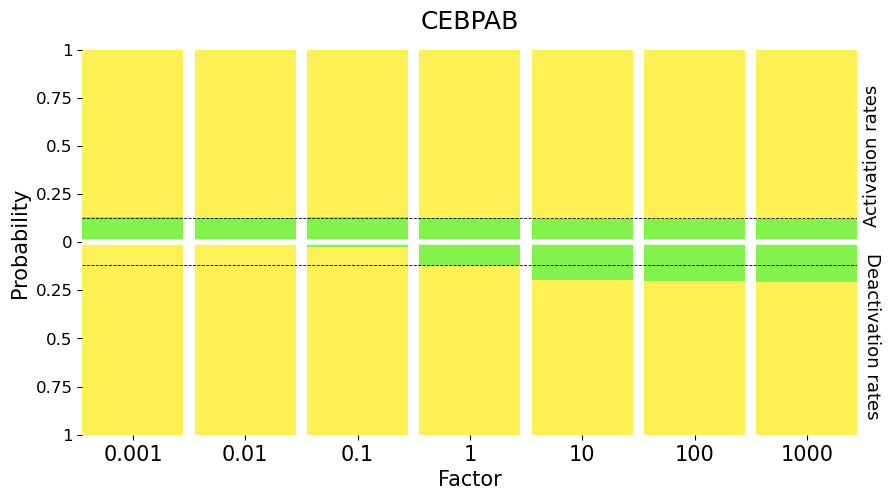

In [20]:
# Plot the impacts of parameter changes for each node in individual bar plots.

# Define the lists for "up" and "down" differences, which will be used to represent the differentiation in the barplot
diff_up_list = [1] * 7  # Represents full height bars for the "up" condition
diff_down_list = [-1] * 7  # Represents full height bars for the "down" condition

# Iterate over each column in the DataFrame `PSA_plot_df_filtered`
for col_name in PSA_plot_df_filtered.columns:
    temp_dict = {}  # Initialize a temporary dictionary to store rates and values for 'up' and 'down'
    
    # Extract the Series (column data) for the current column
    series = PSA_plot_df_filtered[col_name]
    
    # Create the list of rates, which are the second element of the index (assumed to be tuples)
    temp_dict['rates'] = [PSA_plot_df_filtered.index[i][1] for i in range(int(len(PSA_plot_df_filtered)/2))]
    
    # Extract and store the 'up' and 'down' values for the corresponding rates
    temp_dict['up'] = series.loc['up'].reindex(temp_dict['rates']).tolist()
    temp_dict['down'] = series.loc['down'].reindex(temp_dict['rates']).tolist()
    
    # Create a DataFrame from the temporary dictionary
    df = pd.DataFrame(temp_dict)
    
    # Multiply the 'down' values by -1 to invert them (for plotting on the negative side of the y-axis)
    df['down'] = df['down'] * -1
    
    # Convert 'rates' to string for consistent labeling
    df['rates'] = df['rates'].astype(str)
    
    # Set 'rates' as the index of the DataFrame
    df.set_index('rates', inplace=True)
  
    # Generate a range object for bar positions
    rates = range(len(df))
    
    # Create a plot figure and axis
    fig, axes = plt.subplots(figsize=(10,5))
    
    # Plot background bars for the "up" and "down" conditions using `diff_up_list` and `diff_down_list`
    axes.bar(rates, diff_up_list, align='center', color='#FFF055', zorder=0, width=0.9)
    axes.bar(rates, diff_down_list, align='center', color='#FFF055', zorder=0, width=0.9)
    
    # Overlay the actual "up" and "down" data on top of the background bars
    axes.bar(rates, df['up'], align='center', color='#84F24C', zorder=1, width=0.9)
    axes.bar(rates, df['down'], align='center', color='#84F24C', zorder=1, width=0.9)
    
    # Set the title for the plot, based on the column name
    axes.set_title(col_name, fontsize=18, pad=15, color='black')
    
    # Draw a white horizontal line at y=0 to separate the up and down bars
    axes.axhline(y=0, color='white', linestyle='-', linewidth=4, zorder=3)
    
    # Draw dashed black lines at the up and down values for rate 1.0
    axes.axhline(y=df.loc['1.0']['up'], color='black', linestyle='--', linewidth=0.6, zorder=3)
    axes.axhline(y=df.loc['1.0']['down'], color='black', linestyle='--', linewidth=0.6, zorder=3)
    
    # Remove plot margins
    plt.margins(0, 0)
    
    # Set y-axis label
    axes.set_ylabel('Probability', fontsize=15)
    
    # Set x-axis label
    axes.set_xlabel('Factor', fontsize=15)

    # Customize x-axis tick labels with rates formatted as strings
    plt.xticks(rates, [(f"{float(v):.10g}") for v in df.index.tolist()], fontsize=15)
    
    # Define y-axis ticks and labels
    y_ticks= [1, 0.75, 0.5, 0.25, 0, -0.25, -0.5, -0.75, -1]
    axes.yaxis.set_major_locator(FixedLocator(y_ticks))  # Set fixed y-tick positions
    axes.yaxis.set_major_formatter(FixedFormatter([str(abs(tick)) for tick in y_ticks]))  # Format y-tick labels as absolute values
    plt.yticks(fontsize=12)
    
    # Add text labels to the right side of the plot for activation and deactivation rates
    axes.text(6.5, 0.1, 'Activation rates', rotation=90, fontsize=13)
    axes.text(6.5, -0.9, 'Deactivation rates', rotation=270, fontsize=13)
    
    # Hide all the plot spines (the box around the plot)
    for spine in axes.spines.values():
        spine.set_visible(False)


These barplots display the impact of individual nodes. In each barplot, the upper side denote the variations in the activation rates, whereas the bottom side denotes the variations in the deactivation rates. In each bar, the green section represents the probability of the proliferative attractor, and the yellow section represents the probability of the differentiated attractor. The dashed lines denote the probabilities corresponding to the default transition rates (set to 1).